<a href="https://colab.research.google.com/github/Seng-Pan/myReadability/blob/main/ShallowMethod_OrdinalRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Method 1: Burmese Shallow Features

In [ ]:
!pip install pandas
!pip install myword

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 7.5 MB/s eta 0:00:00


#### Set Up

In [ ]:
from myword import SyllableTokenizer
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
from io import StringIO
import seaborn as sns
import pandas as pd
import logging
import os
import re
import glob as std_glob

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
SEGMENTED_DATA = Path("/content/drive/MyDrive/Readability_Shallow_Method/Segmented")
POS_TAGGED = Path("/content/drive/MyDrive/Readability_Shallow_Method/POS_Tagged")
WORD_LIST = Path("/content/drive/MyDrive/Readability_Shallow_Method/wordlist")
PROVERB_LIST = Path("/content/drive/MyDrive/Readability_Shallow_Method/unique_proverbs.seg.txt")

SAVE_DIR = Path("/content/drive/MyDrive/Readability_Shallow_Method/")
SAVE_DIR.mkdir(parents=True, exist_ok=True)


In [ ]:
# Regex pattern for stackword
stacked_word_pattern = re.compile(r'[\u1000-\u109F]*\u1039[\u1000-\u109F]+[\u1000-\u109F]*')


#### Helper Function

In [ ]:
def get_grade_files(folder_path, file_extension='tsv', file_pattern='G{}.word.segmented'):
    """Get grade-specific files (G1, G2, ..., G12) from a folder"""
    grade_files = []
    for grade in range(1, 13):  # G1 to G12
        pattern = f"{file_pattern.format(grade)}.{file_extension}"
        file_path = os.path.join(folder_path, pattern)
        if os.path.exists(file_path):
            grade_files.append(file_path)
    return grade_files


def get_pos_files(folder_path):
    """Get POS-tagged files for all grades"""
    pos_files = std_glob.glob(os.path.join(folder_path, 'G*.word.segmented_Text_tagged.txt'))
    return sorted(pos_files)


#### POS Data Processing

In [ ]:
def read_pos_tagged_file(filepath):
    """Read POS-tagged file and parse into individual texts"""
    texts_with_tags = []
    current_text = []

    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    line = line.strip()
                    if not line:  # Empty line indicates text boundary
                        if current_text:
                            texts_with_tags.append(current_text)
                            current_text = []
                        continue

                    if '\t' in line:
                        parts = line.split('\t', 1)
                        if len(parts) == 2:
                            word, tag = parts[0].strip(), parts[1].strip()
                            if word and tag:
                                current_text.append((word, tag))
                except Exception as e:
                    print(f"    Warning: Skipping malformed line {line_num} in {os.path.basename(filepath)}: {e}")
                    continue

        # Don't forget the last text if file doesn't end with empty line
        if current_text:
            texts_with_tags.append(current_text)

    except Exception as e:
        print(f"  Error reading POS file {filepath}: {e}")
        return []

    return texts_with_tags


def load_all_pos_data():
    """Load POS data for all available grades"""
    pos_files = get_pos_files(POS_TAGGED)
    pos_data_by_grade = {}

    for pos_file in pos_files:
        # Extract grade from filename (e.g., 'G1.word.segmented_Text_tagged.txt' -> 'G1')
        filename = os.path.basename(pos_file)
        grade_match = re.match(r'(G\d+)', filename)

        if grade_match:
            grade_key = grade_match.group(1)
            print(f"Loading POS data for {grade_key}...")

            pos_texts = read_pos_tagged_file(pos_file)
            if pos_texts:
                pos_data_by_grade[grade_key] = pos_texts
                print(f"  Loaded {len(pos_texts)} texts for {grade_key}")

    return pos_data_by_grade

print("POS processing functions defined!")


POS processing functions defined!


#### Segmented Data Processing

In [ ]:
def load_segmented_data():
    """Load all segmented text data with robust error handling"""
    tsv_files = get_grade_files(SEGMENTED_DATA, 'tsv', 'G{}.word.segmented')

    if not tsv_files:
        print("No segmented TSV files found! Please check your folder path.")
        return None

    print(f"Found {len(tsv_files)} segmented files:")
    for file_path in tsv_files:
        print(f"  {os.path.basename(file_path)}")

    dataframes = []
    for tsv_file in tsv_files:
        try:
            df = pd.read_csv(tsv_file, sep='\t')
            df['Grade'] = os.path.basename(tsv_file).split('.')[0]  # Extract 'G1', 'G2', etc.
            print(f"  Loaded {len(df)} texts from {os.path.basename(tsv_file)}")
            dataframes.append(df)
        except pd.errors.ParserError as e:
            print(f"  ParserError in {os.path.basename(tsv_file)}: {e}")
            try:
                df = pd.read_csv(tsv_file, sep='\t', on_bad_lines='skip')
                df['Grade'] = os.path.basename(tsv_file).split('.')[0]
                print(f"  Loaded {len(df)} texts (skipping bad lines) from {os.path.basename(tsv_file)}")
                dataframes.append(df)
            except Exception as inner_e:
                print(f"  Failed to recover {os.path.basename(tsv_file)}: {inner_e}")
        except Exception as e:
            print(f"  Error loading {os.path.basename(tsv_file)}: {e}")

    if dataframes:
        df = pd.concat(dataframes, ignore_index=True)

        if df.shape[1] == 3 and 'Text' not in df.columns:
            df.columns = ['ID', 'Text', 'Grade']

        df = df.dropna(subset=['Text', 'Grade'], how='any')

        df['Grade'] = df['Grade'].astype(str).str.extract(r'(\d+)')
        df = df.dropna(subset=['Grade'])                   # Drop rows where grade wasn't extracted
        df['Grade'] = df['Grade'].astype(int)

        return df
    else:
        return None


#### Feature Calculation Functions

In [ ]:
def calculate_stacked_word_ratio(text):
    """Calculate the ratio of stacked words in the text"""
    if not text or not text.strip():
        return 0.0

    words = text.split()
    if not words:
        return 0.0

    # Find stacked words using regex pattern
    stacked_words = len(stacked_word_pattern.findall(text))
    total_words = len(words)

    return stacked_words / total_words


def count_syllables_burmese(word):
    """Count syllables in a Burmese word (approximate method)"""
    if not word:
        return 0

    myanmar_chars = re.findall(r'[\u1000-\u109F]', word)
    if not myanmar_chars:
        return 1

    consonants = re.findall(r'[\u1000-\u1021]', word)

    vowels_tones = re.findall(r'[\u102C-\u1032\u1036-\u1039\u103A-\u103F]', word)

    syllable_count = len(consonants)

    virama_count = word.count('\u1039')
    syllable_count -= virama_count

    return max(1, syllable_count)  # At least 1 syllable per word


def calculate_average_word_length(text):
    """Calculate average word length (syllables per word)"""
    if not text or not text.strip():
        return 0.0

    words = text.split()
    if not words:
        return 0.0

    total_syllables = 0
    for word in words:
        total_syllables += count_syllables_burmese(word)

    return len(words) / total_syllables


def calculate_conjunction_ratio_from_pos(tagged_pairs):
    """Calculate the ratio of conjunctions from POS-tagged pairs"""
    if not tagged_pairs:
        return 0.0

    total_words = len(tagged_pairs)
    conjunction_count = 0

    for word, tag in tagged_pairs:
        tag_lower = tag.lower().strip()
        if tag_lower == 'conj':
            conjunction_count += 1

    return conjunction_count / total_words


def calculate_pos_ratios(tagged_pairs):
    """Calculate PPM, ADV, and CONJ ratios from POS-tagged pairs"""
    if not tagged_pairs:
        return {'ppm_ratio': 0.0, 'adv_ratio': 0.0, 'conj_ratio': 0.0}

    total_words = len(tagged_pairs)
    ppm_count = 0
    adv_count = 0
    conj_count = 0

    for word, tag in tagged_pairs:
        tag_lower = tag.lower().strip()
        if tag_lower == 'ppm':
            ppm_count += 1
        elif tag_lower == 'adv':
            adv_count += 1
        elif tag_lower == 'conj':
            conj_count += 1

    return {
        'ppm_ratio': ppm_count / total_words,
        'adv_ratio': adv_count / total_words,
        'conj_ratio': conj_count / total_words
    }


# def calculate_proverb_ratio(text):
#     """Placeholder for proverb ratio calculation"""
#     # TODO: Implement proverb detection logic later
#     return 0.0


print("Feature calculation functions defined!")

Feature calculation functions defined!


In [ ]:
# Load Grade-Specific Word Lists
grade_word_lists = {}

# Range from 1 to 12 for G1 to G12
for grade in range(1, 13):
    wordlist_path = f'{WORD_LIST}/G{grade}.wordlist.tsv'
    if os.path.exists(wordlist_path):
        df_wordlist = pd.read_csv(wordlist_path, sep='\t')
        grade_word_lists[f'G{grade}'] = set(df_wordlist['Word'].str.strip().str.lower())

print(f"Loaded word lists for grades: {list(grade_word_lists.keys())}")


Loaded word lists for grades: ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12']


In [ ]:
# Build Level-Based Word Lists
level_word_lists = {
    'Primary': set(),
    'Lower Secondary': set(),
    'Upper Secondary': set()
}

for grade, words in grade_word_lists.items():
    g_num = int(grade[1:])
    if g_num <= 5:
        level_word_lists['Primary'].update(words)
    elif g_num <= 9:
        level_word_lists['Lower Secondary'].update(words)
    else:
        level_word_lists['Upper Secondary'].update(words)

# Directory to save level word lists
output_dir = f"{WORD_LIST}/levels"
# os.makedirs(output_dir, exist_ok=True)

# Save each level word list into a .tsv file
for level, words in level_word_lists.items():
    level_filename = f"{output_dir}/{level.replace(' ', '_')}.wordlist.tsv"
    df_level = pd.DataFrame(sorted(words), columns=['Word'])
    df_level.to_csv(level_filename, sep='\t', index=False)
    print(f"Saved {len(words)} words to {level_filename}")


Saved 5360 words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/levels/Primary.wordlist.tsv
Saved 7521 words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/levels/Lower_Secondary.wordlist.tsv
Saved 9246 words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/levels/Upper_Secondary.wordlist.tsv


In [ ]:
# Create Exclusive Grade-Level Word Lists
def create_exclusive_grade_word_lists(grade_word_lists):
    """Create exclusive word lists where each grade contains words unique to that level"""
    g1_words = grade_word_lists.get('G1', set())
    g2_words = grade_word_lists.get('G2', set())
    g3_words = grade_word_lists.get('G3', set())
    g4_words = grade_word_lists.get('G4', set())
    g5_words = grade_word_lists.get('G5', set())
    g6_words = grade_word_lists.get('G6', set())
    g7_words = grade_word_lists.get('G7', set())
    g8_words = grade_word_lists.get('G8', set())
    g9_words = grade_word_lists.get('G9', set())
    g10_words = grade_word_lists.get('G10', set())
    g11_words = grade_word_lists.get('G11', set())
    g12_words = grade_word_lists.get('G12', set())


    exclusive_lists = {
        'G1': g1_words.copy(),
        'G2': g2_words - g1_words,
        'G3': g3_words - g1_words - g2_words,
        'G4': g4_words - g1_words - g2_words - g3_words,
        'G5': g5_words - g1_words - g2_words - g3_words - g4_words,
        'G6': g6_words - g1_words - g2_words - g3_words - g4_words - g5_words,
        'G7': g7_words - g1_words - g2_words - g3_words - g4_words - g5_words - g6_words,
        'G8': g8_words - g1_words - g2_words - g3_words - g4_words - g5_words - g6_words - g7_words,
        'G9': g9_words - g1_words - g2_words - g3_words - g4_words - g5_words - g6_words - g7_words - g8_words,
        'G10': g10_words - g1_words - g2_words - g3_words - g4_words - g5_words - g6_words - g7_words - g8_words - g9_words,
        'G11': g11_words - g1_words - g2_words - g3_words - g4_words - g5_words - g6_words - g7_words - g8_words - g9_words - g10_words,
        'G12': g12_words - g1_words - g2_words - g3_words - g4_words - g5_words - g6_words - g7_words - g8_words - g9_words - g10_words - g11_words
    }

    return exclusive_lists

def calculate_grade_word_ratios(text, exclusive_word_lists):
    """Calculate word list ratios using exclusive grade-level word lists"""
    if not text or not text.strip():
        return {f'{grade}_WordRatio': 0.0 for grade in exclusive_word_lists.keys()}

    words = [word.strip().lower() for word in text.split() if word.strip()]
    total_words = len(words)

    if total_words == 0:
        return {f'{grade}_WordRatio': 0.0 for grade in exclusive_word_lists.keys()}

    ratios = {}
    for grade, word_set in exclusive_word_lists.items():
        words_in_grade = sum(1 for word in words if word in word_set)
        ratios[f'{grade}_WordRatio'] = words_in_grade / total_words

    return ratios

grade_word_lists_exclusive = create_exclusive_grade_word_lists(grade_word_lists)

output_dir = f"{WORD_LIST}/grade_exclusive"
for grade, words in grade_word_lists_exclusive.items():
    file_path = f"{output_dir}/{grade.replace(' ', '_')}_exclusive.wordlist.tsv"
    df_level = pd.DataFrame(sorted(words), columns=['Word'])
    df_level.to_csv(file_path, sep='\t', index=False)
    print(f"Saved {len(words)} exclusive words to {file_path}")

print(f"Created exclusive word lists for {len(grade_word_lists_exclusive)} grades")


Saved 1519 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G1_exclusive.wordlist.tsv
Saved 1384 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G2_exclusive.wordlist.tsv
Saved 672 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G3_exclusive.wordlist.tsv
Saved 1064 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G4_exclusive.wordlist.tsv
Saved 721 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G5_exclusive.wordlist.tsv
Saved 1530 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G6_exclusive.wordlist.tsv
Saved 1213 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/grade_exclusive/G7_exclusive.wordlist.tsv
Saved 1088 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordl

In [ ]:
# Step 1: Build Exclusive Level Word Lists
def create_exclusive_level_word_lists(exclusive_grade_lists):
    """Create exclusive word lists for Primary, Lower Secondary, and Upper Secondary"""
    # Collect words for each level
    primary_grades = [f'G{i}' for i in range(1, 6)]
    lower_sec_grades = [f'G{i}' for i in range(6, 10)]
    upper_sec_grades = [f'G{i}' for i in range(10, 13)]

    primary_words = set().union(*(exclusive_grade_lists.get(g, set()) for g in primary_grades))
    lower_words = set().union(*(exclusive_grade_lists.get(g, set()) for g in lower_sec_grades))
    upper_words = set().union(*(exclusive_grade_lists.get(g, set()) for g in upper_sec_grades))

    # Make levels exclusive of previous levels
    lower_words_exclusive = lower_words - primary_words
    upper_words_exclusive = upper_words - primary_words - lower_words

    return {
        'Primary': primary_words,
        'Lower Secondary': lower_words_exclusive,
        'Upper Secondary': upper_words_exclusive
    }

# Step 2: Create the exclusive level lists
exclusive_level_word_lists = create_exclusive_level_word_lists(grade_word_lists_exclusive)

# Step 3: Save the exclusive level word lists to .tsv
output_dir = f"{WORD_LIST}/levels_exclusive"
#os.makedirs(output_dir, exist_ok=True)

for level, words in exclusive_level_word_lists.items():
    file_path = f"{output_dir}/{level.replace(' ', '_')}_exclusive.wordlist.tsv"
    df_level = pd.DataFrame(sorted(words), columns=['Word'])
    df_level.to_csv(file_path, sep='\t', index=False)
    print(f"Saved {len(words)} exclusive words to {file_path}")


Saved 5360 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/levels_exclusive/Primary_exclusive.wordlist.tsv
Saved 4634 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/levels_exclusive/Lower_Secondary_exclusive.wordlist.tsv
Saved 4471 exclusive words to /content/drive/MyDrive/Readability_Shallow_Method/wordlist/levels_exclusive/Upper_Secondary_exclusive.wordlist.tsv


#### Main Processing Function

In [ ]:

def extract_features_for_dataset(df, pos_data_by_grade):
    """Extract all features for the entire dataset"""
    feature_results = []

    print("Extracting features...")
    for idx, row in df.iterrows():
        if idx % 100 == 0:
            print(f"  Processing text {idx+1}/{len(df)}")

        text = row['Text']
        grade = row['Grade']
        num_proverb = row['proverb_count']
        grade_key = f'G{grade}'

        # text-based features
        stacked_ratio = calculate_stacked_word_ratio(text)
        avg_word_length = calculate_average_word_length(text)
        # conjunction_ratio = calculate_conjunction_ratio_from_pos(text)

        # POS-based features
        ppm_ratio = 0.0
        adv_ratio = 0.0
        conjunction_ratio = 0.0

        if grade_key in pos_data_by_grade:
            pos_texts = pos_data_by_grade[grade_key]
            grade_rows = df[df['Grade'] == grade]
            grade_idx = list(grade_rows.index).index(idx) if idx in grade_rows.index else -1

            if 0 <= grade_idx < len(pos_texts):
                pos_ratios = calculate_pos_ratios(pos_texts[grade_idx])
                ppm_ratio = pos_ratios['ppm_ratio']
                adv_ratio = pos_ratios['adv_ratio']
                conjunction_ratio = pos_ratios['conj_ratio']


        grade_ratios = calculate_grade_word_ratios(text, grade_word_lists_exclusive)
        level_ratios = calculate_grade_word_ratios(text, exclusive_level_word_lists)

        features = {
            'Text': text,
            'Grade': grade,
            'stacked_word_ratio': stacked_ratio,
            'avg_word_length': avg_word_length,
            'conjunction_ratio': conjunction_ratio,
            'ppm_ratio': ppm_ratio,
            'adv_ratio': adv_ratio,
            'proverb_ratio': num_proverb ,
        }
        features.update(grade_ratios)   # Add G1-G12 word ratios
        features.update(level_ratios)   # Add Primary, Lower, Upper word ratios
        feature_results.append(features)

    return pd.DataFrame(feature_results)


def add_education_levels(df):
    """Add education level classification"""
    def classify_grade(grade):
        if 1 <= grade <= 5:
            return 'Primary'
        elif 6 <= grade <= 9:
            return 'Lower Secondary'
        elif 10 <= grade <= 12:
            return 'Upper Secondary'
        else:
            return 'Unknown'

    df['Education_Level'] = df['Grade'].apply(classify_grade)
    print("added education level column")
    return df


sylTok = SyllableTokenizer()
def add_proverb_presence(df):

  with open(PROVERB_LIST, "r", encoding="utf-8") as f:
    unique_proverbs = [line.strip() for line in f if line.strip()]  # remove empty lines

  # Step 3: Count how many proverbs appear in each row of the 'text' column
  def count_proverbs_in_text(text, proverbs):
    # Split the input text into syllables
    text_syllables = sylTok.tokenize(text)
    count = 0

    for proverb in proverbs:
        proverb_syllables = sylTok.tokenize(proverb)

        len_p = len(proverb_syllables)
        for i in range(len(text_syllables) - len_p + 1):
            if text_syllables[i:i+len_p] == proverb_syllables:
                count += 1
                break  # Count each proverb once even if repeated in text

    return count


  # Step 4: Apply the function to the DataFrame
  df["proverb_count"] = df["Text"].apply(lambda x: count_proverbs_in_text(str(x), unique_proverbs))
  return df


print("Main processing functions defined!")


Main processing functions defined!


#### Feature Correlation

In [ ]:
def analyze_feature_correlations(df):
    """Analyze correlations between features by grade and education level"""
    print("\n" + "="*60)
    print("CORRELATION ANALYSIS")
    print("="*60)

    feature_cols = ['stacked_word_ratio', 'avg_word_length', 'conjunction_ratio', 'ppm_ratio', 'adv_ratio', 'proverb_ratio']

    print("\n1. Overall Feature Correlations:")
    correlation_matrix = df[feature_cols + ['Grade']].corr()
    print(correlation_matrix.round(4))

    print("\n2. Feature Correlations by Education Level:")
    for level in ['Primary', 'Lower Secondary', 'Upper Secondary']:
        level_data = df[df['Education_Level'] == level]
        if len(level_data) > 1:
            print(f"\n{level} ({len(level_data)} texts):")
            level_corr = level_data[feature_cols].corr()
            print(level_corr.round(4))

    print("\n3. Feature Statistics by Grade:")
    grade_stats = df.groupby('Grade')[feature_cols].agg(['mean', 'std']).round(4)
    print(grade_stats)

    print("\n4. Feature Statistics by Education Level:")
    level_stats = df.groupby('Education_Level')[feature_cols].agg(['mean', 'std']).round(4)
    print(level_stats)

    return correlation_matrix, grade_stats, level_stats


#### Visualization

In [ ]:
def create_visualizations(df, save_dir):
    """Create and save visualization plots"""
    print("\n5. Creating visualizations...")

    feature_cols = ['stacked_word_ratio', 'avg_word_length', 'conjunction_ratio', 'ppm_ratio', 'adv_ratio', 'proverb_ratio']

    plt.style.use('default')
    sns.set_palette("husl")


    # 1. Correlation heatmap
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[feature_cols + ['Grade']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_dir / 'correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()


    # 2. Feature trends by grade
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, feature in enumerate(feature_cols):
        grade_means = df.groupby('Grade')[feature].mean()
        grade_stds = df.groupby('Grade')[feature].std()

        axes[i].errorbar(grade_means.index, grade_means.values, yerr=grade_stds.values, marker='o', capsize=5, capthick=2, linewidth=2, markersize=8)
        axes[i].set_title(f'{feature.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Grade', fontsize=12)
        axes[i].set_ylabel('Value', fontsize=12)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xticks(range(1, 13))

    plt.suptitle('Feature Trends Across Grades', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_dir / 'feature_trends_by_grade.png', dpi=300, bbox_inches='tight')
    plt.close()


    # 3. Box plots by education level
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, feature in enumerate(feature_cols):
        sns.boxplot(data=df, x='Education_Level', y=feature, ax=axes[i])
        axes[i].set_title(f'{feature.replace("_", " ").title()}', fontsize=14, fontweight='bold')
        axes[i].set_xlabel('Education Level', fontsize=12)
        axes[i].set_ylabel('Value', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Feature Distributions by Education Level', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_dir / 'feature_distributions_by_level.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"  Visualizations saved to {save_dir}/")


#### Main Execution

In [ ]:
def main():

    print("\n1. Loading segmented data...")
    df = load_segmented_data()

    if df is None:
        print("Failed to load data. Please check your file paths.")
        return

    print(f"Successfully loaded {len(df)} texts across grades {sorted(df['Grade'].unique())}")


    print("\n2. Loading POS-tagged data...")
    pos_data_by_grade = load_all_pos_data()
    print(f"Successfully loaded POS data for grades: {sorted(pos_data_by_grade.keys())}")



    results_df = add_proverb_presence(df)


    print("\n3. Extracting features...")
    results_df = extract_features_for_dataset(results_df, pos_data_by_grade)

    results_df = add_education_levels(results_df)
    print(results_df.columns)

    print(f"\nFeature extraction completed!")
    print(f"Dataset shape: {results_df.shape}")
    print(f"Columns: {list(results_df.columns)}")


    correlation_matrix, grade_stats, level_stats = analyze_feature_correlations(results_df)

    create_visualizations(results_df, SAVE_DIR)


    print(f"\n6. Saving results...")

    output_file = (SAVE_DIR / "burmese_enhanced_features.csv")
    results_df.to_csv(output_file, index=False)
    print(f"  Enhanced dataset saved to: {output_file}")

    correlation_file = (SAVE_DIR / "feature_correlations.csv")
    correlation_matrix.to_csv(correlation_file)
    print(f"  Correlation matrix saved to: {correlation_file}")

    grade_stats_file = SAVE_DIR / "grade_statistics.csv"
    grade_stats.to_csv(grade_stats_file)
    print(f"  Grade statistics saved to: {grade_stats_file}")

    level_stats_file = SAVE_DIR / "level_statistics.csv"
    level_stats.to_csv(level_stats_file)
    print(f"  Education level statistics saved to: {level_stats_file}")

    print("\n" + "="*60)
    print("ENHANCED FEATURE EXTRACTION COMPLETED!")
    print("="*60)

    return results_df


if __name__ == "__main__":
    results = main()


1. Loading segmented data...
Found 12 segmented files:
  G1.word.segmented.tsv
  G2.word.segmented.tsv
  G3.word.segmented.tsv
  G4.word.segmented.tsv
  G5.word.segmented.tsv
  G6.word.segmented.tsv
  G7.word.segmented.tsv
  G8.word.segmented.tsv
  G9.word.segmented.tsv
  G10.word.segmented.tsv
  G11.word.segmented.tsv
  G12.word.segmented.tsv
  Loaded 523 texts from G1.word.segmented.tsv
  Loaded 251 texts from G2.word.segmented.tsv
  Loaded 302 texts from G3.word.segmented.tsv
  Loaded 702 texts from G4.word.segmented.tsv
  Loaded 259 texts from G5.word.segmented.tsv
  Loaded 667 texts from G6.word.segmented.tsv
  Loaded 932 texts from G7.word.segmented.tsv
  Loaded 978 texts from G8.word.segmented.tsv
  Loaded 1157 texts from G9.word.segmented.tsv
  Loaded 1134 texts from G10.word.segmented.tsv
  Loaded 2514 texts from G11.word.segmented.tsv
  Loaded 1810 texts from G12.word.segmented.tsv
Successfully loaded 11229 texts across grades [np.int64(1), np.int64(2), np.int64(3), np.int64

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Readability_Shallow_Method/burmese_enhanced_features.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11229 entries, 0 to 11228
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Text                       11229 non-null  object 
 1   Grade                      11229 non-null  int64  
 2   stacked_word_ratio         11229 non-null  float64
 3   avg_word_length            11229 non-null  float64
 4   conjunction_ratio          11229 non-null  float64
 5   ppm_ratio                  11229 non-null  float64
 6   adv_ratio                  11229 non-null  float64
 7   proverb_ratio              11229 non-null  int64  
 8   G1_WordRatio               11229 non-null  float64
 9   G2_WordRatio               11229 non-null  float64
 10  G3_WordRatio               11229 non-null  float64
 11  G4_WordRatio               11229 non-null  float64
 12  G5_WordRatio               11229 non-null  float64
 13  G6_WordRatio               11229 non-null  flo

In [ ]:
df.groupby('Grade')['proverb_ratio'].value_counts()

Grade  proverb_ratio
1      0                 522
       3                   1
2      0                 247
       1                   3
       2                   1
3      0                 299
       1                   3
4      0                 687
       1                  10
       2                   5
5      0                 255
       1                   4
6      0                 656
       1                   4
       2                   2
       8                   2
       4                   1
       5                   1
       6                   1
7      0                 926
       1                   4
       2                   1
       3                   1
8      0                 977
       1                   1
9      0                1150
       1                   4
       2                   2
       3                   1
10     0                1127
       1                   6
       2                   1
11     0                2494
       1                  19
       2                   1
12     0                1779
       1                  28
       3                   2
       2                   1
Name: count, dtype: int64

In [ ]:
print("SIMPLE TABLE VIEW - FEATURE SUMMARY BY GRADE")

if 'results_df' in locals():

    feature_cols = ['stacked_word_ratio', 'ppm_ratio', 'adv_ratio']

    print(f"\n{'Grade':<6} {'Count':<6} {'Stacked_Mean':<12} {'Stacked_Std':<11} {'PPM_Mean':<9} {'PPM_Std':<8} {'ADV_Mean':<9} {'ADV_Std':<8}")
    print("-" * 80)

    for grade in sorted(results['Grade'].unique()):
        grade_data = results[results['Grade'] == grade]

        stacked_mean = grade_data['stacked_word_ratio'].mean()
        stacked_std = grade_data['stacked_word_ratio'].std()
        ppm_mean = grade_data['ppm_ratio'].mean()
        ppm_std = grade_data['ppm_ratio'].std()
        adv_mean = grade_data['adv_ratio'].mean()
        adv_std = grade_data['adv_ratio'].std()
        conj_mean = grade_data['conjunction_ratio'].mean()
        conj_std = grade_data['conjunction_ratio'].std()
        avg_word_length_mean = grade_data['avg_word_length'].mean()
        avg_word_length_std = grade_data['avg_word_length'].std()

        print(f"G{grade:<5} {len(grade_data):<6} {stacked_mean:<12.4f} {stacked_std:<11.4f} {ppm_mean:<9.4f} {ppm_std:<8.4f} {adv_mean:<9.4f} {adv_std:<8.4f}")


if 'results' in locals():
    summary_for_display = []

    for grade in sorted(results['Grade'].unique()):
        grade_data = results[results['Grade'] == grade]

        summary_for_display.append({
            'Grade': f'G{grade}',
            'Text_Count': len(grade_data),
            'Stacked_Mean': round(grade_data['stacked_word_ratio'].mean(), 4),
            'Stacked_Std': round(grade_data['stacked_word_ratio'].std(), 4),
            'PPM_Mean': round(grade_data['ppm_ratio'].mean(), 4),
            'PPM_Std': round(grade_data['ppm_ratio'].std(), 4),
            'ADV_Mean': round(grade_data['adv_ratio'].mean(), 4),
            'ADV_Std': round(grade_data['adv_ratio'].std(), 4),
            'CONJ_Mean' : round(grade_data['conjunction_ratio'].mean(), 4),
            'CONJ_Std' : round(grade_data['conjunction_ratio'].std(), 4),
            'Avg_Word_Length_Mean' : round(grade_data['avg_word_length'].mean(), 4),
            'Avg_Word_Length_Std' : round(grade_data['avg_word_length'].std(), 4)
        })

    display_df = pd.DataFrame(summary_for_display)

    # print(f"\nPANDAS DATAFRAME VIEW:")
    # print("-" * 50)
    # print(display_df.to_string(index=False))


    if 'SAVE_DIR' in locals():
        display_file = (SAVE_DIR / "simple_feature_table.csv")
        display_df.to_csv(display_file, index=False)
        print(f"\n✓ Simple table saved to: {display_file}")


    print(f"\n SAMPLE TEXTS WITH FEATURES:")
    print("-" * 60)
    sample_df = results[['Grade', 'stacked_word_ratio', 'ppm_ratio', 'adv_ratio', 'conjunction_ratio', 'avg_word_length', 'Text']].head(10)
    for idx, row in sample_df.iterrows():
        print(f"G{row['Grade']} | Stacked: {row['stacked_word_ratio']:.4f} | PPM: {row['ppm_ratio']:.4f} | ADV: {row['adv_ratio']:.4f} | CONJ: {row['conjunction_ratio']:.4f} | Avg_Word_Length: {row['avg_word_length']:.4f}")
        print(f"Text: {row['Text'][:100]}...")
        print("-" * 60)

else:
    print(" results_df not found. Please run the feature extraction first.")


SIMPLE TABLE VIEW - FEATURE SUMMARY BY GRADE

✓ Simple table saved to: /content/drive/MyDrive/Readability_Data_G1-12/simple_feature_table.csv

 SAMPLE TEXTS WITH FEATURES:
------------------------------------------------------------
G1 | Stacked: 0.0000 | PPM: 0.0000 | ADV: 0.2500 | CONJ: 0.0000 | Avg_Word_Length: 0.2857
Text: ရင်းရင်းနှီးနှီး မိတ်ဆက် ကြ ရအောင်...
------------------------------------------------------------
G1 | Stacked: 0.0000 | PPM: 0.0000 | ADV: 0.2500 | CONJ: 0.0000 | Avg_Word_Length: 0.5000
Text: စကား ချိုချို ပြော ရအောင်...
------------------------------------------------------------
G1 | Stacked: 0.0000 | PPM: 0.0714 | ADV: 0.0000 | CONJ: 0.0000 | Avg_Word_Length: 0.7368
Text: ပုံ ထဲ မှာ ဘာ တွေ မြင် ရ သလဲ ၊ ပြော ကြည့် ကြ ရအောင် ။...
------------------------------------------------------------
G1 | Stacked: 0.0000 | PPM: 0.0000 | ADV: 0.0000 | CONJ: 0.0000 | Avg_Word_Length: 0.7143
Text: ကလေး တွေ ဘာ ဖြစ် နေ ကြ ပြီ ထင် သလဲ ။...
------------------------------------

## SVM Ordinal Regression

In [ ]:
!pip install scikit-learn mord

  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=67b7a93efc1401708d7bc29736d95c0fe8c81ec1a2736b96d3d7a79934dce0da
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
from mord import LogisticIT, LogisticAT, LogisticSE  # Different ordinal regression models
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Load dataframe
df = pd.read_csv("/content/drive/MyDrive/Readability_Shallow_Method/burmese_enhanced_features.csv")

In [ ]:
# Map Education_Level to ordinal labels
level_order = ['Primary', 'Lower Secondary', 'Upper Secondary']
level_encoder = LabelEncoder()
level_encoder.classes_ = np.array(level_order)
df['Level_Label'] = level_encoder.transform(df['Education_Level'])


# Feature sets
grade_cols = [f'G{i}_WordRatio' for i in range(1, 13)]
level_cols = ['Primary_WordRatio', 'Lower Secondary_WordRatio', 'Upper Secondary_WordRatio']
base_cols = ['stacked_word_ratio','avg_word_length','conjunction_ratio','ppm_ratio','adv_ratio','proverb_ratio']


In [ ]:
# Check class distribution
print("Class Distribution:")
print(df['Education_Level'].value_counts())

print("\nClass Distribution (proportions):")
print(df['Education_Level'].value_counts(normalize=True))

Class Distribution:
Education_Level
Upper Secondary    5458
Lower Secondary    3734
Primary            2037
Name: count, dtype: int64

Class Distribution (proportions):
Education_Level
Upper Secondary    0.486063
Lower Secondary    0.332532
Primary            0.181405
Name: proportion, dtype: float64


#### Orginal approach

In [ ]:
# Helper function: train and evaluate model
def train_and_evaluate(X, y, label='Model'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticIT()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== {label} ===")
    print("Accuracy (Overall):", accuracy_score(y_test, y_pred))

    # Convert numeric labels back to Education_Level strings
    true_labels = level_encoder.inverse_transform(y_test)
    pred_labels = level_encoder.inverse_transform(y_pred)

    # Classification report
    print("\nClassification Report (F1, Precision, Recall, Support):")
    report = classification_report(
        true_labels,
        pred_labels,
        labels=level_order,
        zero_division=0,
        output_dict=True
    )
    print(report)

    # Weighted averages
    weighted_precision = weighted_recall = weighted_f1 = total_support = 0
    for lvl in level_order:
        precision = report[lvl]['precision']
        recall = report[lvl]['recall']
        f1 = report[lvl]['f1-score']
        support = report[lvl]['support']

        weighted_precision += precision * support
        weighted_recall += recall * support
        weighted_f1 += f1 * support
        total_support += support

    weighted_precision /= total_support
    weighted_recall /= total_support
    weighted_f1 /= total_support

    print(f"\nWeighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall:    {weighted_recall:.4f}")
    print(f"Weighted F1-score:  {weighted_f1:.4f}")

    # Accuracy by Education Level
    df_level = pd.DataFrame({'True': true_labels, 'Pred': pred_labels})
    print("\nAccuracy by Education Level:")
    print(df_level.groupby('True').apply(lambda g: np.mean(g['True'] == g['Pred'])))

    # Accuracy by Grade
    test_grades = df.iloc[y_test.index]['Grade']
    df_grade = pd.DataFrame({'True': true_labels, 'Grade': test_grades, 'Pred': pred_labels})
    print("\nAccuracy by Grade:")
    print(df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred'])))

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=level_order)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=level_order, yticklabels=level_order, cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Feature Importance
    feature_importance = model.coef_
    feature_names = X.columns
    print("\nFeature Importance (Coefficient):")
    for name, coef in sorted(zip(feature_names, feature_importance), key=lambda x: -abs(x[1])):
        print(f"{name:30s}: {coef:.4f}")



=== Grade-Level Word Ratios ===
Accuracy (Overall): 0.6090828138913624

Classification Report (F1, Precision, Recall, Support):
{'Primary': {'precision': 0.8163265306122449, 'recall': 0.19184652278177458, 'f1-score': 0.3106796116504854, 'support': 417.0}, 'Lower Secondary': {'precision': 0.4582441113490364, 'recall': 0.5699067909454061, 'f1-score': 0.5080118694362018, 'support': 751.0}, 'Upper Secondary': {'precision': 0.7084019769357496, 'recall': 0.7977736549165121, 'f1-score': 0.7504363001745201, 'support': 1078.0}, 'accuracy': 0.6090828138913624, 'macro avg': {'precision': 0.6609908729656769, 'recall': 0.5198423228812309, 'f1-score': 0.5230425937537357, 'support': 2246.0}, 'weighted avg': {'precision': 0.6447937765027474, 'recall': 0.6090828138913624, 'f1-score': 0.5877295830779041, 'support': 2246.0}}

Weighted Precision: 0.6448
Weighted Recall:    0.6091
Weighted F1-score:  0.5877

Accuracy by Education Level:
True
Lower Secondary    0.569907
Primary            0.191847
Upper Se

/tmp/ipython-input-1960158958.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_level.groupby('True').apply(lambda g: np.mean(g['True'] == g['Pred'])))
/tmp/ipython-input-1960158958.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred'])))


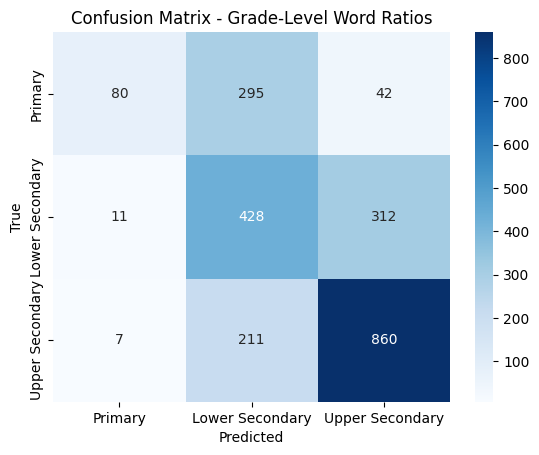


Feature Importance (Coefficient):
G11_WordRatio                 : 14.2497
G10_WordRatio                 : 13.7932
G12_WordRatio                 : 9.3679
G1_WordRatio                  : -6.5773
G2_WordRatio                  : -5.5273
G3_WordRatio                  : -5.0736
G4_WordRatio                  : -4.7797
G7_WordRatio                  : -3.7057
G8_WordRatio                  : -3.4546
G9_WordRatio                  : -3.2372
G6_WordRatio                  : -3.1441
avg_word_length               : 2.7738
G5_WordRatio                  : -1.9116
ppm_ratio                     : 1.6933
conjunction_ratio             : 1.6188
adv_ratio                     : -0.7957
stacked_word_ratio            : -0.6274
proverb_ratio                 : -0.0379

=== Level-Based Word Ratios ===
Accuracy (Overall): 0.6255565449688335

Classification Report (F1, Precision, Recall, Support):
{'Primary': {'precision': 0.5441176470588235, 'recall': 0.08872901678657075, 'f1-score': 0.15257731958762888, 'support':

/tmp/ipython-input-1960158958.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_level.groupby('True').apply(lambda g: np.mean(g['True'] == g['Pred'])))
/tmp/ipython-input-1960158958.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred'])))


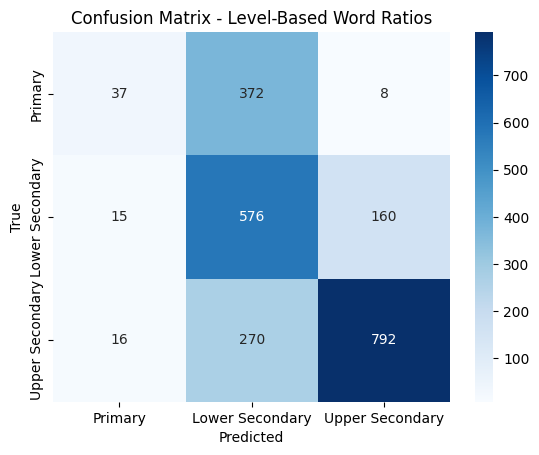


Feature Importance (Coefficient):
Upper Secondary_WordRatio     : 20.9076
Primary_WordRatio             : -11.8516
Lower Secondary_WordRatio     : -9.0563
avg_word_length               : 1.8026
adv_ratio                     : -1.5328
ppm_ratio                     : 1.4514
conjunction_ratio             : 1.1157
stacked_word_ratio            : -0.3177
proverb_ratio                 : -0.0309

=== Level + Grade Word Ratios ===
Accuracy (Overall): 0.6625111308993766

Classification Report (F1, Precision, Recall, Support):
{'Primary': {'precision': 0.8076923076923077, 'recall': 0.2014388489208633, 'f1-score': 0.32245681381957775, 'support': 417.0}, 'Lower Secondary': {'precision': 0.505, 'recall': 0.8069241011984021, 'f1-score': 0.6212198872373142, 'support': 751.0}, 'Upper Secondary': {'precision': 0.8471337579617835, 'recall': 0.7402597402597403, 'f1-score': 0.7900990099009901, 'support': 1078.0}, 'accuracy': 0.6625111308993766, 'macro avg': {'precision': 0.7199420218846971, 'recall': 0.5

/tmp/ipython-input-1960158958.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_level.groupby('True').apply(lambda g: np.mean(g['True'] == g['Pred'])))
/tmp/ipython-input-1960158958.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred'])))


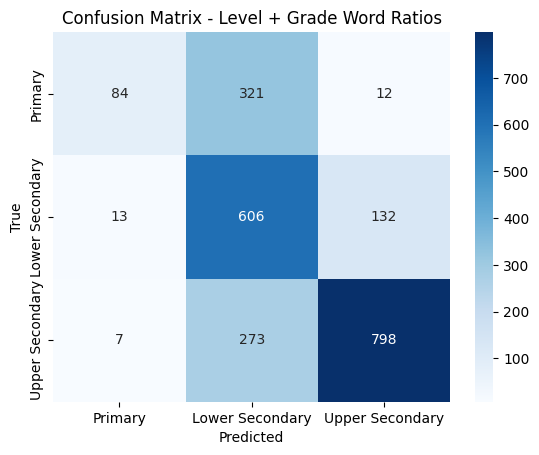


Feature Importance (Coefficient):
Upper Secondary_WordRatio     : 18.0229
Primary_WordRatio             : -9.9488
Lower Secondary_WordRatio     : -8.0746
G10_WordRatio                 : 7.0359
G11_WordRatio                 : 6.6554
G12_WordRatio                 : 4.3316
G1_WordRatio                  : -3.7008
avg_word_length               : 2.9016
G2_WordRatio                  : -2.5322
G7_WordRatio                  : -2.3337
G4_WordRatio                  : -2.1243
G3_WordRatio                  : -2.0693
G8_WordRatio                  : -2.0562
G9_WordRatio                  : -1.9763
ppm_ratio                     : 1.7584
G6_WordRatio                  : -1.7085
conjunction_ratio             : 1.3502
adv_ratio                     : -0.9539
stacked_word_ratio            : -0.6157
G5_WordRatio                  : 0.4778
proverb_ratio                 : -0.0368


In [ ]:
# Model 1: Grade-level features only
X_grade = df[base_cols + grade_cols]
y_level = df['Level_Label']
train_and_evaluate(X_grade, y_level, label="Grade-Level Word Ratios")


# Model 2: Level-only features
X_level = df[base_cols + level_cols]
train_and_evaluate(X_level, y_level, label="Level-Based Word Ratios")


# Model 3: Both Level and Grade features
X_combined = df[base_cols + level_cols + grade_cols]
train_and_evaluate(X_combined, y_level, label="Level + Grade Word Ratios")


#### Enhanced with multiple improvement

In [ ]:
def analyze_feature_importance(pipeline, X, y, feature_names, model_name, X_test=None, y_test=None):

    model = pipeline.named_steps['model']

    selected_features = feature_names
    if 'feature_selection' in pipeline.named_steps:
        selector = pipeline.named_steps['feature_selection']
        if hasattr(selector, 'get_support'):
            mask = selector.get_support()
            selected_features = feature_names[mask]
            print(f"Features selected by {type(selector).__name__}: {len(selected_features)} out of {len(feature_names)}")
            print(f"Selected features: {list(selected_features)}")
        elif hasattr(selector, 'scores_'):
            feature_scores = selector.scores_
            selected_indices = selector.get_support(indices=True)
            selected_features = feature_names[selected_indices]
            print(f"Top {len(selected_features)} features selected by SelectKBest:")
            for idx, (feat, score) in enumerate(zip(selected_features, feature_scores[selected_indices])):
                print(f"  {feat:30s}: {score:.4f}")

    # Extract importance values
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
        print(f"\nOrdinal Regression Coefficients (Higher absolute value = more important):")
        importance_data = []
        for i, (feature, coef) in enumerate(zip(selected_features, coefficients)):
            importance_data.append((feature, coef, abs(coef)))
            print(f"  {feature:30s}: {coef:8.4f} (|{abs(coef):.4f}|)")

        # Top 10 features by absolute coefficient
        importance_data.sort(key=lambda x: x[2], reverse=True)
        print(f"\nTop 10 Most Important Features (by absolute coefficient):")
        for i, (feature, coef, abs_coef) in enumerate(importance_data[:10]):
            print(f"  {i+1:2d}. {feature:30s}: {coef:8.4f} (|{abs_coef:.4f}|)")

    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        print(f"\nRandom Forest Feature Importances:")
        importance_data = []
        for feature, importance in zip(selected_features, importances):
            importance_data.append((feature, importance))
            print(f"  {feature:30s}: {importance:.4f}")

        # Top 10 features
        importance_data.sort(key=lambda x: x[1], reverse=True)
        print(f"\nTop 10 Most Important Features:")
        for i, (feature, importance) in enumerate(importance_data[:10]):
            print(f"  {i+1:2d}. {feature:30s}: {importance:.4f}")


    if X_test is not None and y_test is not None:
        print(f"\n2. PERMUTATION IMPORTANCE:")
        print("-" * 40)
        try:
            perm_importance = permutation_importance(
                pipeline, X_test, y_test,
                n_repeats=10,
                random_state=42,
                scoring='accuracy'
            )
            original_features = X_test.columns if hasattr(X_test, 'columns') else [f'feature_{i}' for i in range(X_test.shape[1])]

            print(f"Permutation Importance (Higher = more important for prediction):")
            perm_data = []
            for i, (feature, importance, std) in enumerate(zip(original_features,
                                                              perm_importance.importances_mean,
                                                              perm_importance.importances_std)):
                perm_data.append((feature, importance, std))
                print(f"  {feature:30s}: {importance:.4f} ± {std:.4f}")

            # Top 10 features by permutation importance
            perm_data.sort(key=lambda x: x[1], reverse=True)
            print(f"\nTop 10 Features by Permutation Importance:")
            for i, (feature, importance, std) in enumerate(perm_data[:10]):
                print(f"  {i+1:2d}. {feature:30s}: {importance:.4f} ± {std:.4f}")

        except Exception as e:
            print(f"Could not calculate permutation importance: {e}")


    # Visualization
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
        plt.figure(figsize=(12, 8))
        abs_coefs = np.abs(coefficients)
        sorted_indices = np.argsort(abs_coefs)[-15:]  # Top 15
        sorted_features = selected_features[sorted_indices]
        sorted_coefs = coefficients[sorted_indices]
        plt.barh(range(len(sorted_coefs)), sorted_coefs)
        plt.yticks(range(len(sorted_coefs)), sorted_features)
        plt.xlabel('Coefficient Value')
        plt.title(f'Top 15 Feature Coefficients - {model_name}')
        plt.tight_layout()
        plt.show()

    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        plt.figure(figsize=(12, 8))
        sorted_indices = np.argsort(importances)[-15:]
        sorted_features = selected_features[sorted_indices]
        sorted_importances = importances[sorted_indices]
        plt.barh(range(len(sorted_importances)), sorted_importances)
        plt.yticks(range(len(sorted_importances)), sorted_features)
        plt.xlabel('Feature Importance')
        plt.title(f'Top 15 Feature Importances - {model_name}')
        plt.tight_layout()
        plt.show()

    return pipeline


In [ ]:
def train_and_evaluate_enhanced(X, y, label='Model', use_smote=True, feature_selection='rfe', scaling='standard', pca_components=None, model_type='logistic_it'):

    # Split the data first
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Initialize components for pipeline
    steps = []

    # 1. Scaling
    if scaling == 'standard':
        scaler = StandardScaler()
    elif scaling == 'robust':
        scaler = RobustScaler()
    elif scaling == 'minmax':
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler:
        steps.append(('scaler', scaler))

    # 2. Handle class imbalance with SMOTE
    if use_smote:
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        steps.append(('smote', smote))

    # 3. Feature Selection
    if feature_selection == 'selectk':
        selector = SelectKBest(f_classif, k=min(15, X.shape[1]))
        steps.append(('feature_selection', selector))
    elif feature_selection == 'rfe':
        # Use a simple model for RFE
        estimator = RandomForestClassifier(n_estimators=10, random_state=42)
        selector = RFE(estimator, n_features_to_select=min(15, X.shape[1]))
        steps.append(('feature_selection', selector))

    # 4. PCA
    if pca_components:
        pca = PCA(n_components=min(pca_components, X.shape[1]))
        steps.append(('pca', pca))

    # 5. Model selection
    if model_type == 'logistic_it':
        model = LogisticIT()
    elif model_type == 'logistic_at':
        model = LogisticAT()
    elif model_type == 'logistic_se':
        model = LogisticSE()
    elif model_type == 'random_forest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)

    steps.append(('model', model))

    # Create pipeline
    if use_smote:
        pipeline = ImbPipeline(steps)
    else:
        pipeline = Pipeline([step for step in steps if step[0] != 'smote'])

    # Cross-validation for better evaluation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n=== {label} ===")
    print(f"Cross-validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print("Test Accuracy:", accuracy_score(y_test, y_pred))

    # Convert numeric labels back to Education_Level strings
    true_labels = level_encoder.inverse_transform(y_test)
    pred_labels = level_encoder.inverse_transform(y_pred)

    # Classification report
    print("\nClassification Report:")
    report = classification_report(
        true_labels,
        pred_labels,
        labels=level_order,
        zero_division=0,
        output_dict=True
    )

    # Print detailed metrics
    for level in level_order:
        metrics = report[level]
        print(f"{level:18s}: Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1-score']:.3f}, Support={int(metrics['support'])}")

    # Weighted averages
    print(f"\nWeighted Avg: Precision={report['weighted avg']['precision']:.4f}, "
          f"Recall={report['weighted avg']['recall']:.4f}, F1={report['weighted avg']['f1-score']:.4f}")

    # Accuracy by Grade
    if 'Grade' in df.columns:
        test_indices = X_test.index if hasattr(X_test, 'index') else range(len(X_test))
        test_grades = df.loc[test_indices, 'Grade'] if hasattr(X_test, 'index') else df.iloc[test_indices]['Grade']
        df_grade = pd.DataFrame({'True': true_labels, 'Grade': test_grades, 'Pred': pred_labels})
        print("\nAccuracy by Grade:")
        grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))
        print(grade_accuracy)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=level_order)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=level_order, yticklabels=level_order, cmap='Blues')
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    analyze_feature_importance(pipeline, X_train, y_train, X.columns, label, X_test, y_test)

    return pipeline, cv_scores.mean()


def hyperparameter_tuning(X, y, label='Hyperparameter Tuning'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Define pipeline with hyperparameter options
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('feature_selection', SelectKBest()),
        ('model', LogisticIT())
    ])

    # Parameter grid
    param_grid = {
        'feature_selection__k': [10, 15, 20, min(25, X.shape[1])],
        'model__alpha': [0.1, 1.0, 10.0, 100.0],  # Regularization parameter for LogisticIT
    }

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"\n=== {label} ===")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy with best parameters: {test_accuracy:.4f}")

    best_pipeline = grid_search.best_estimator_
    analyze_feature_importance(best_pipeline, X_train, y_train, X.columns, f"{label} - Best Model", X_test, y_test)

    return grid_search


#### Experiment with different configurations


=== Baseline: Grade-Level Features ===
Cross-validation Accuracy: 0.5981 (+/- 0.0075)
Test Accuracy: 0.6046304541406946

Classification Report:
Primary           : Precision=0.796, Recall=0.192, F1=0.309, Support=407
Lower Secondary   : Precision=0.456, Recall=0.576, F1=0.509, Support=747
Upper Secondary   : Precision=0.705, Recall=0.778, F1=0.740, Support=1092

Weighted Avg: Precision=0.6387, Recall=0.6046, F1=0.5850

Accuracy by Grade:
Grade
1     0.542553
2     0.326087
3     0.122807
4     0.032468
5     0.000000
6     0.515625
7     0.597701
8     0.593750
9     0.577075
10    0.728889
11    0.775304
12    0.812332
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


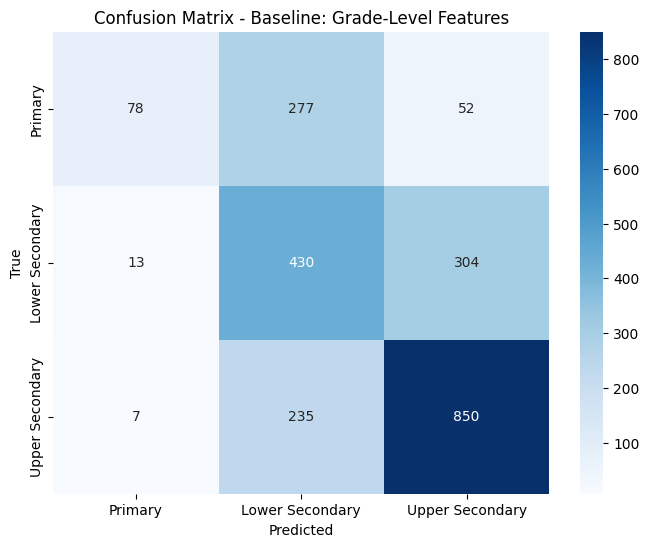


Ordinal Regression Coefficients (Higher absolute value = more important):
  stacked_word_ratio            :  -0.6894 (|0.6894|)
  avg_word_length               :   2.9760 (|2.9760|)
  conjunction_ratio             :   1.5161 (|1.5161|)
  ppm_ratio                     :   1.8789 (|1.8789|)
  adv_ratio                     :  -0.7589 (|0.7589|)
  proverb_ratio                 :  -0.0622 (|0.0622|)
  G1_WordRatio                  :  -6.7493 (|6.7493|)
  G2_WordRatio                  :  -5.6338 (|5.6338|)
  G3_WordRatio                  :  -5.0580 (|5.0580|)
  G4_WordRatio                  :  -4.9489 (|4.9489|)
  G5_WordRatio                  :  -1.3943 (|1.3943|)
  G6_WordRatio                  :  -3.0678 (|3.0678|)
  G7_WordRatio                  :  -3.8292 (|3.8292|)
  G8_WordRatio                  :  -3.4523 (|3.4523|)
  G9_WordRatio                  :  -3.3866 (|3.3866|)
  G10_WordRatio                 :  13.7952 (|13.7952|)
  G11_WordRatio                 :  14.4613 (|14.4613|)
  G12

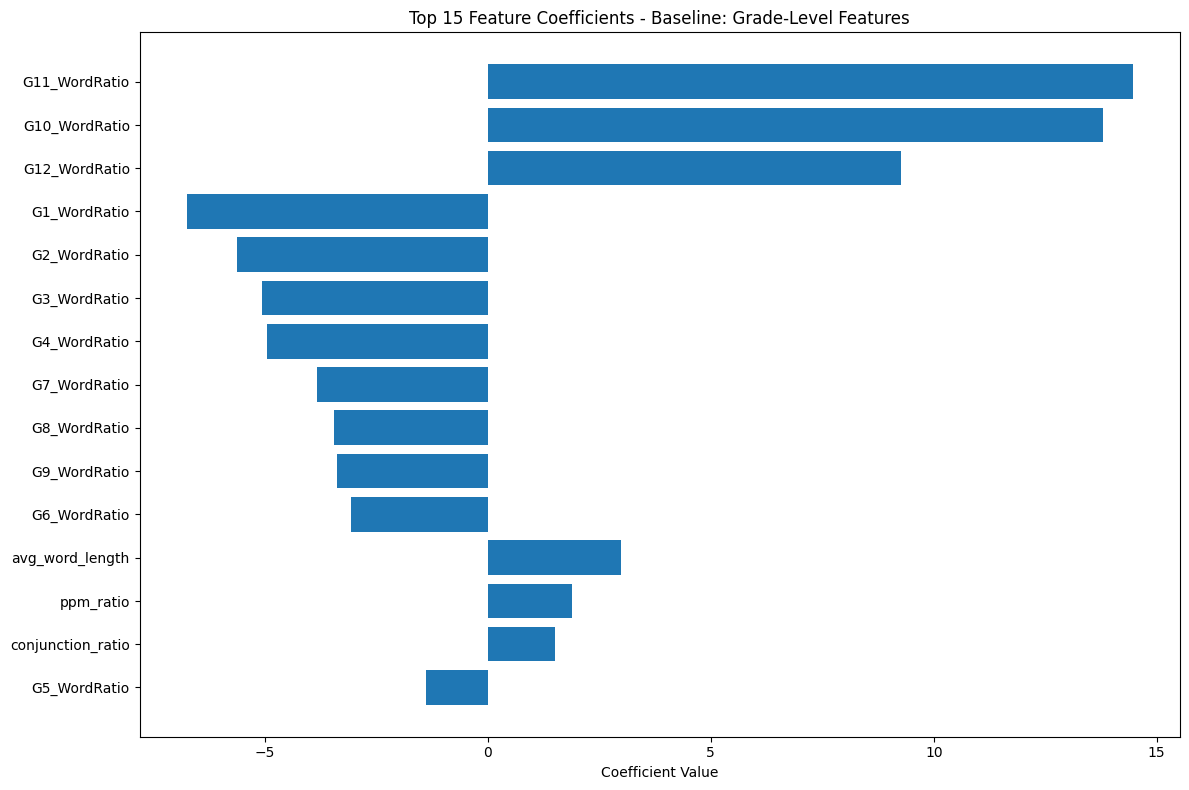


=== Enhanced: Grade-Level + StandardScaler + SMOTE + RFE ===
Cross-validation Accuracy: 0.7287 (+/- 0.0145)
Test Accuracy: 0.7243989314336599

Classification Report:
Primary           : Precision=0.528, Recall=0.786, F1=0.632, Support=407
Lower Secondary   : Precision=0.668, Recall=0.712, F1=0.689, Support=747
Upper Secondary   : Precision=0.919, Recall=0.710, F1=0.801, Support=1092

Weighted Avg: Precision=0.7647, Recall=0.7244, F1=0.7331

Accuracy by Grade:
Grade
1     0.914894
2     0.891304
3     0.789474
4     0.792208
5     0.464286
6     0.796875
7     0.689655
8     0.718750
9     0.679842
10    0.600000
11    0.704453
12    0.782842
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


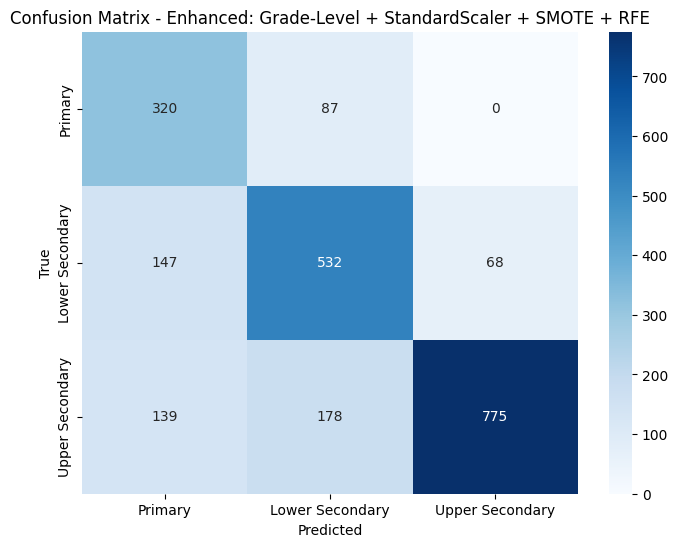

Features selected by RFE: 15 out of 18
Selected features: ['avg_word_length', 'conjunction_ratio', 'ppm_ratio', 'G1_WordRatio', 'G2_WordRatio', 'G3_WordRatio', 'G4_WordRatio', 'G5_WordRatio', 'G6_WordRatio', 'G7_WordRatio', 'G8_WordRatio', 'G9_WordRatio', 'G10_WordRatio', 'G11_WordRatio', 'G12_WordRatio']

Ordinal Regression Coefficients (Higher absolute value = more important):
  avg_word_length               :   0.4767 (|0.4767|)
  conjunction_ratio             :   0.0604 (|0.0604|)
  ppm_ratio                     :   0.2717 (|0.2717|)
  G1_WordRatio                  :  -2.8414 (|2.8414|)
  G2_WordRatio                  :  -1.5648 (|1.5648|)
  G3_WordRatio                  :  -1.0703 (|1.0703|)
  G4_WordRatio                  :  -1.1598 (|1.1598|)
  G5_WordRatio                  :  -0.4969 (|0.4969|)
  G6_WordRatio                  :  -0.4323 (|0.4323|)
  G7_WordRatio                  :  -0.5108 (|0.5108|)
  G8_WordRatio                  :  -0.3014 (|0.3014|)
  G9_WordRatio          

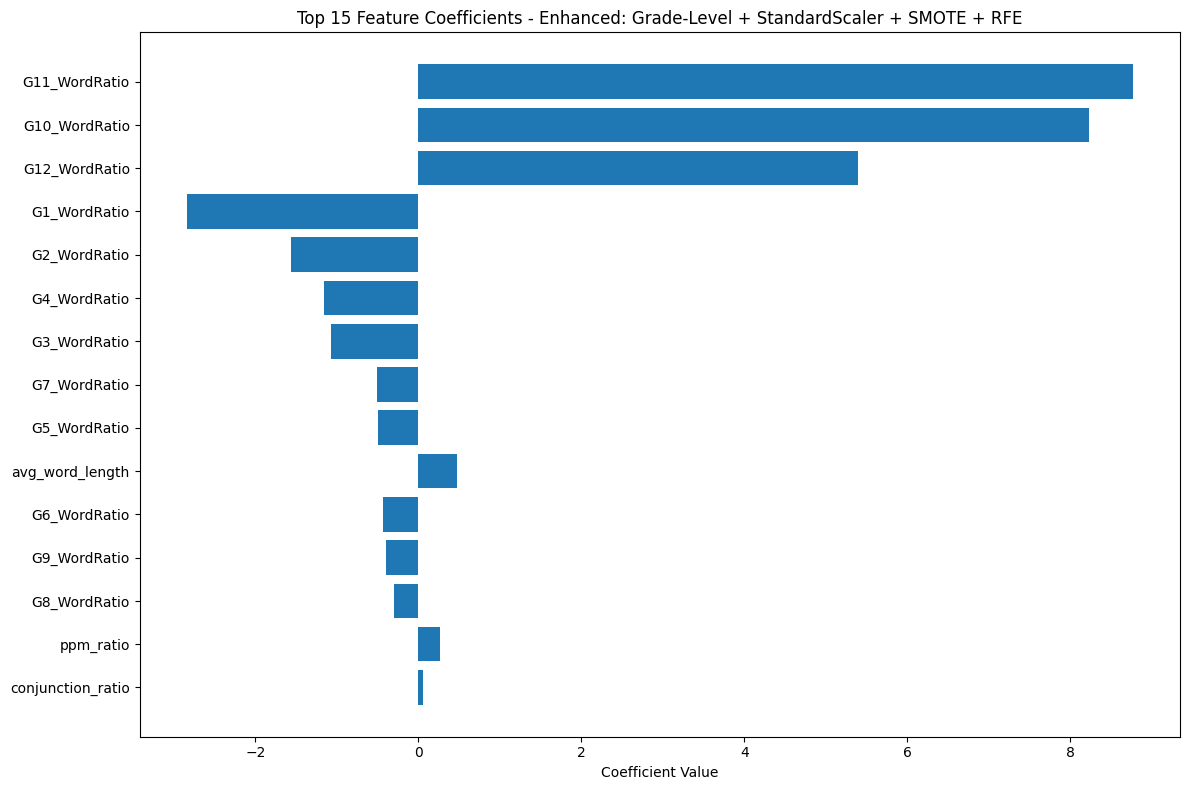

In [ ]:
# Model 1: Grade-level features only (orignal approach's Cross-validation Accuracy: 0.5981 (+/- 0.0075) and Test Accuracy: 0.6046304541406946, for comparison)
X_grade = df[base_cols + grade_cols]
y_level = df['Level_Label']

train_and_evaluate_enhanced(X_grade, y_level, label="Baseline: Grade-Level Features", use_smote=False, feature_selection=None, scaling=None)


# Enhanced Model 1: Grade-level (default LogisticIT)
best_pipeline_1, best_score_1 = train_and_evaluate_enhanced(X_grade, y_level, label="Enhanced: Grade-Level + StandardScaler + SMOTE + RFE", use_smote=True, feature_selection='rfe', scaling='standard')




=== Enhanced: Level-Based + RobustScaler + SMOTE + SelectK ===
Cross-validation Accuracy: 0.7358 (+/- 0.0162)
Test Accuracy: 0.7297417631344613

Classification Report:
Primary           : Precision=0.525, Recall=0.887, F1=0.659, Support=407
Lower Secondary   : Precision=0.697, Recall=0.684, F1=0.691, Support=747
Upper Secondary   : Precision=0.930, Recall=0.702, F1=0.800, Support=1092

Weighted Avg: Precision=0.7790, Recall=0.7297, F1=0.7382

Accuracy by Grade:
Grade
1     0.872340
2     0.978261
3     0.982456
4     0.811688
5     0.946429
6     0.789062
7     0.695402
8     0.708333
9     0.604743
10    0.591111
11    0.698381
12    0.774799
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


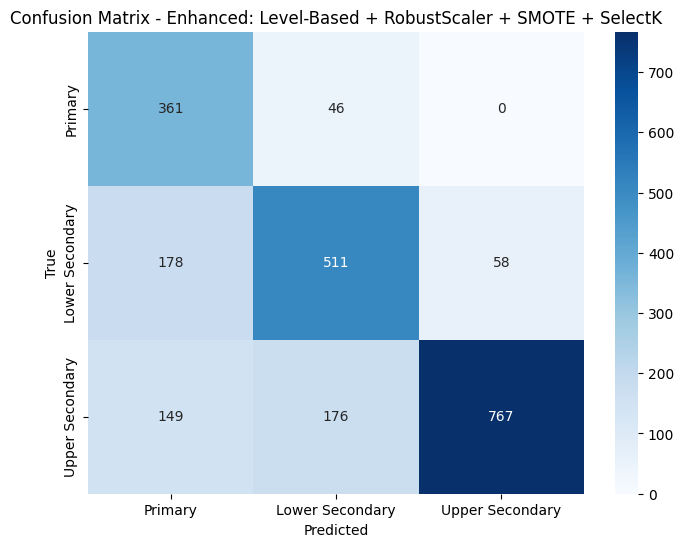

Features selected by SelectKBest: 9 out of 9
Selected features: ['stacked_word_ratio', 'avg_word_length', 'conjunction_ratio', 'ppm_ratio', 'adv_ratio', 'proverb_ratio', 'Primary_WordRatio', 'Lower Secondary_WordRatio', 'Upper Secondary_WordRatio']

Ordinal Regression Coefficients (Higher absolute value = more important):
  stacked_word_ratio            :  -0.0041 (|0.0041|)
  avg_word_length               :   0.3074 (|0.3074|)
  conjunction_ratio             :   0.0337 (|0.0337|)
  ppm_ratio                     :   0.3895 (|0.3895|)
  adv_ratio                     :  -0.0103 (|0.0103|)
  proverb_ratio                 :  -0.0047 (|0.0047|)
  Primary_WordRatio             :  -2.1622 (|2.1622|)
  Lower Secondary_WordRatio     :  -0.7429 (|0.7429|)
  Upper Secondary_WordRatio     :  10.1437 (|10.1437|)

Top 10 Most Important Features (by absolute coefficient):
   1. Upper Secondary_WordRatio     :  10.1437 (|10.1437|)
   2. Primary_WordRatio             :  -2.1622 (|2.1622|)
   3. Lower S

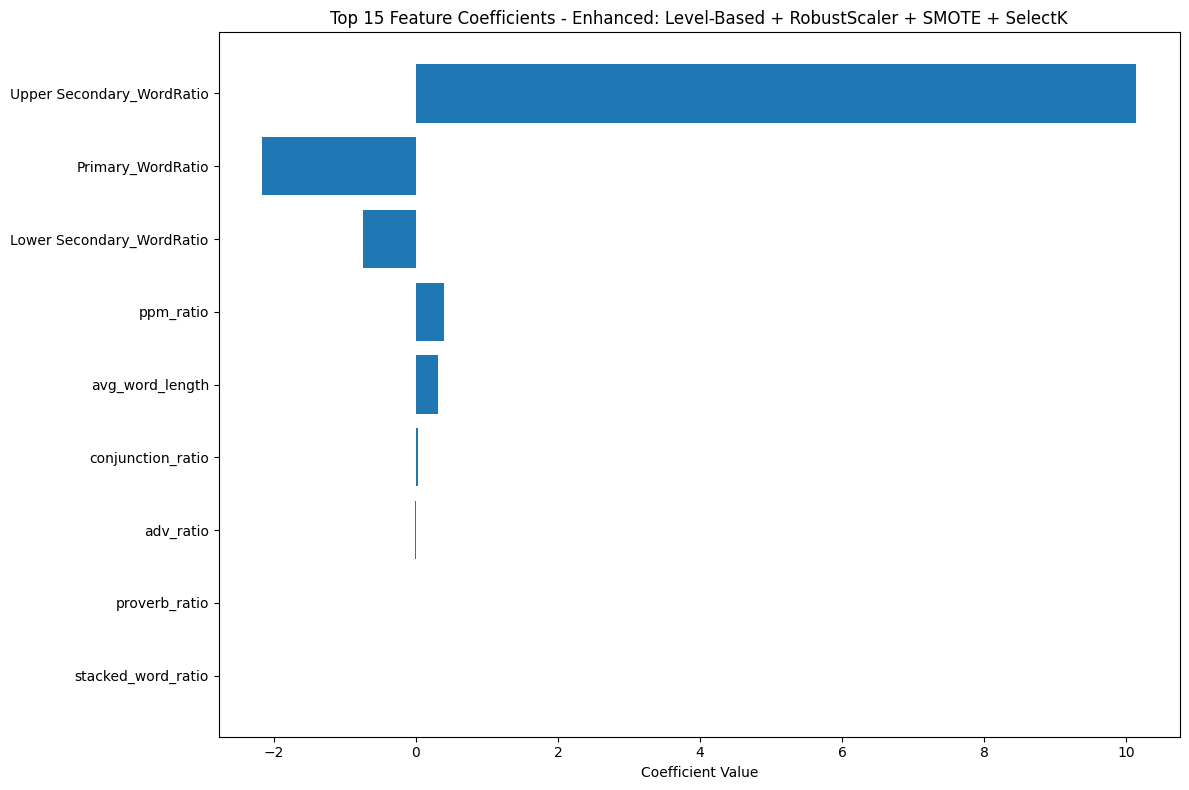

In [ ]:
# Enhanced Model 2: Level-only features (default LogisticIT)

X_level = df[base_cols + level_cols]
best_pipeline_2, best_score_2 = train_and_evaluate_enhanced(X_level, y_level, label="Enhanced: Level-Based + RobustScaler + SMOTE + SelectK", use_smote=True, feature_selection='selectk', scaling='robust')



=== Enhanced: Combined + StandardScaler + SMOTE + SelectK ===
Cross-validation Accuracy: 0.7310 (+/- 0.0187)
Test Accuracy: 0.719946571682992

Classification Report:
Primary           : Precision=0.522, Recall=0.784, F1=0.627, Support=407
Lower Secondary   : Precision=0.661, Recall=0.704, F1=0.682, Support=747
Upper Secondary   : Precision=0.920, Recall=0.707, F1=0.800, Support=1092

Weighted Avg: Precision=0.7618, Recall=0.7199, F1=0.7291

Accuracy by Grade:
Grade
1     0.914894
2     0.891304
3     0.859649
4     0.746753
5     0.500000
6     0.796875
7     0.701149
8     0.718750
9     0.648221
10    0.600000
11    0.700405
12    0.780161
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


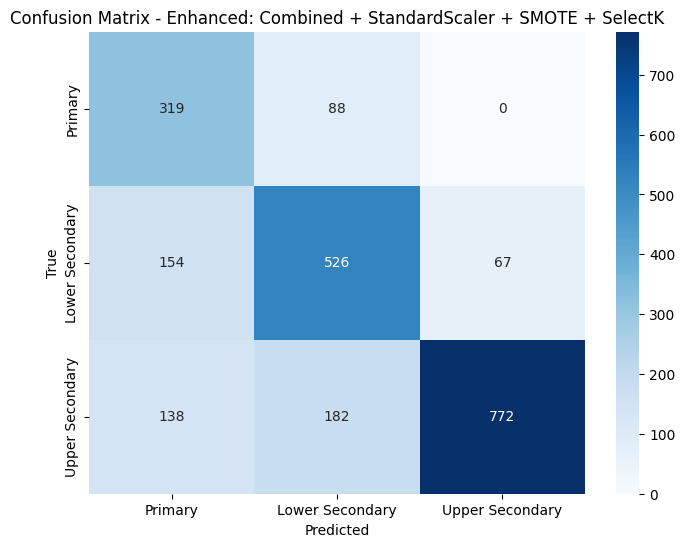

Features selected by SelectKBest: 15 out of 21
Selected features: ['avg_word_length', 'ppm_ratio', 'Primary_WordRatio', 'Lower Secondary_WordRatio', 'Upper Secondary_WordRatio', 'G1_WordRatio', 'G2_WordRatio', 'G5_WordRatio', 'G6_WordRatio', 'G7_WordRatio', 'G8_WordRatio', 'G9_WordRatio', 'G10_WordRatio', 'G11_WordRatio', 'G12_WordRatio']

Ordinal Regression Coefficients (Higher absolute value = more important):
  avg_word_length               :   0.4672 (|0.4672|)
  ppm_ratio                     :   0.2665 (|0.2665|)
  Primary_WordRatio             :  -3.4978 (|3.4978|)
  Lower Secondary_WordRatio     :  -1.2060 (|1.2060|)
  Upper Secondary_WordRatio     :   7.3745 (|7.3745|)
  G1_WordRatio                  :  -0.4189 (|0.4189|)
  G2_WordRatio                  :  -0.0895 (|0.0895|)
  G5_WordRatio                  :   0.1041 (|0.1041|)
  G6_WordRatio                  :  -0.6327 (|0.6327|)
  G7_WordRatio                  :  -0.7145 (|0.7145|)
  G8_WordRatio                  :  -0.4326 (

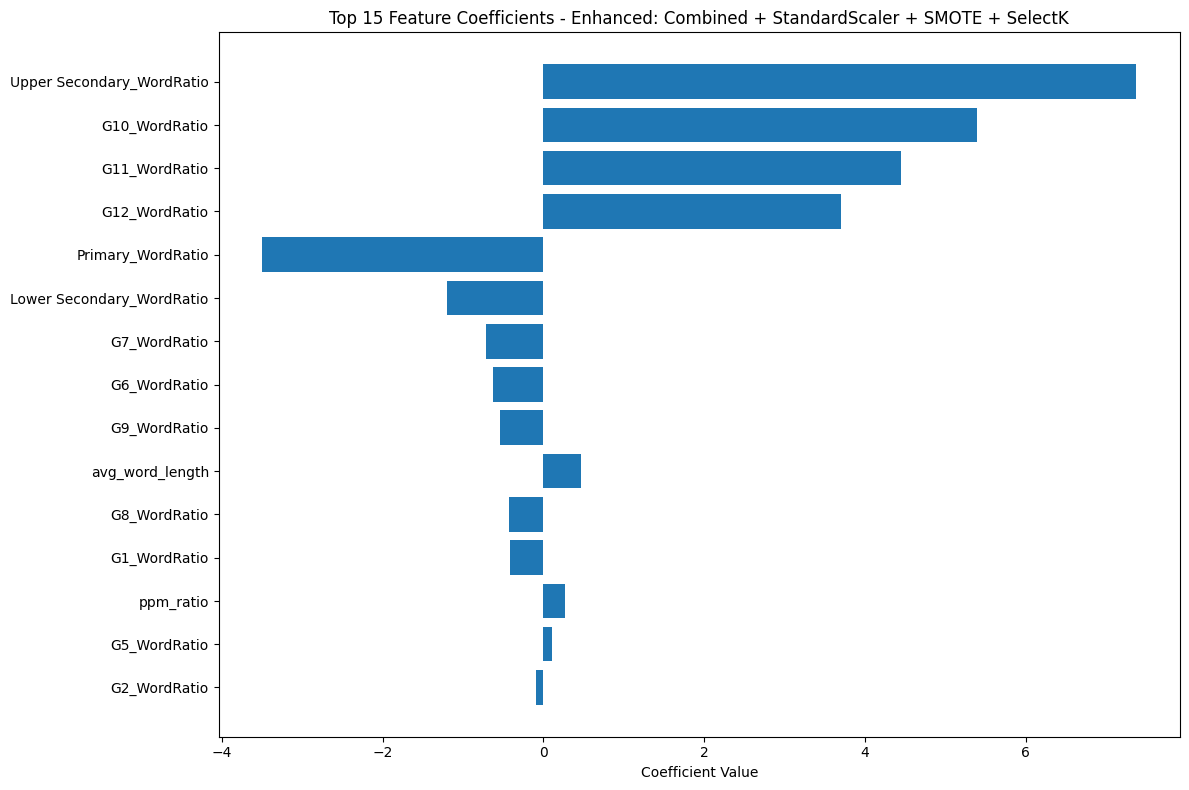

In [ ]:
# Enhanced Model 3: Combined features (default LogisticIT)

X_combined = df[base_cols + level_cols + grade_cols]
best_pipeline_3, best_score_3 = train_and_evaluate_enhanced(X_combined, y_level, label="Enhanced: Combined + StandardScaler + SMOTE + SelectK", use_smote=True, feature_selection='selectk', scaling='standard')



=== Enhanced: Combined + PCA + StandardScaler + SMOTE ===
Cross-validation Accuracy: 0.7310 (+/- 0.0126)
Test Accuracy: 0.7292965271593945

Classification Report:
Primary           : Precision=0.539, Recall=0.801, F1=0.644, Support=407
Lower Secondary   : Precision=0.672, Recall=0.719, F1=0.695, Support=747
Upper Secondary   : Precision=0.920, Recall=0.710, F1=0.801, Support=1092

Weighted Avg: Precision=0.7687, Recall=0.7293, F1=0.7375

Accuracy by Grade:
Grade
1     0.914894
2     0.891304
3     0.789474
4     0.811688
5     0.517857
6     0.812500
7     0.701149
8     0.718750
9     0.683794
10    0.600000
11    0.706478
12    0.780161
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


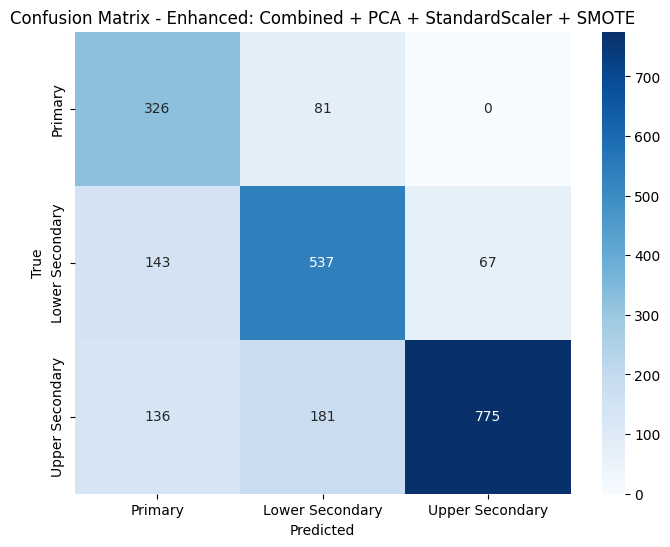


Ordinal Regression Coefficients (Higher absolute value = more important):
  stacked_word_ratio            :  -2.9608 (|2.9608|)
  avg_word_length               :  -2.2768 (|2.2768|)
  conjunction_ratio             :  10.3945 (|10.3945|)
  ppm_ratio                     :   0.6956 (|0.6956|)
  adv_ratio                     :   0.2899 (|0.2899|)
  proverb_ratio                 :   0.9217 (|0.9217|)
  Primary_WordRatio             :   0.1030 (|0.1030|)
  Lower Secondary_WordRatio     :   0.7038 (|0.7038|)
  Upper Secondary_WordRatio     :   0.2657 (|0.2657|)
  G1_WordRatio                  :   0.2312 (|0.2312|)
  G2_WordRatio                  :   0.2130 (|0.2130|)
  G3_WordRatio                  :   1.0843 (|1.0843|)
  G4_WordRatio                  :  -0.1257 (|0.1257|)
  G5_WordRatio                  :   0.7344 (|0.7344|)
  G6_WordRatio                  :   2.4062 (|2.4062|)
  G7_WordRatio                  :   0.6319 (|0.6319|)
  G8_WordRatio                  :  -0.0569 (|0.0569|)
  G9_W

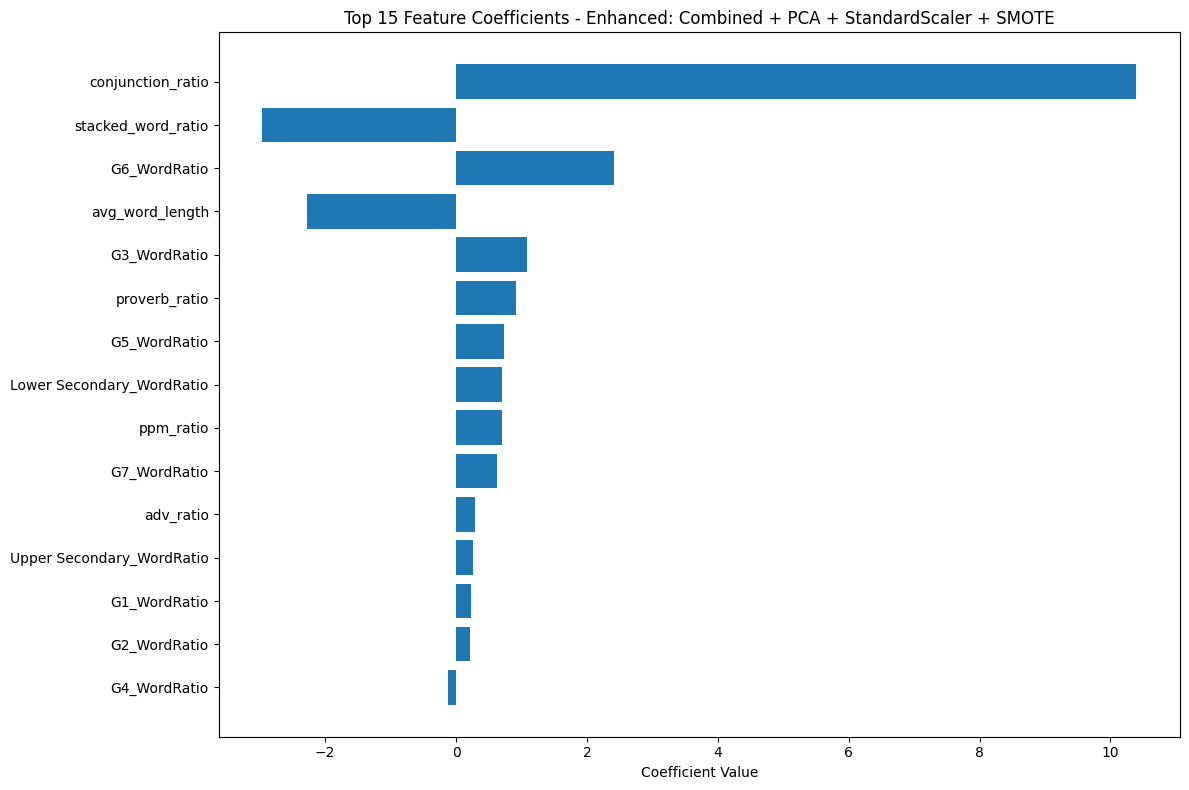

In [ ]:
# Enhanced Model 4: Combined with PCA (default LogisticIT)

best_pipeline_4, best_score_4 = train_and_evaluate_enhanced(X_combined, y_level, label="Enhanced: Combined + PCA + StandardScaler + SMOTE", use_smote=True, feature_selection=None, scaling='standard', pca_components=100)



=== Enhanced: LogisticAT + RobustScaler + SMOTE + PCA ===
Cross-validation Accuracy: 0.7394 (+/- 0.0175)
Test Accuracy: 0.7288512911843277

Classification Report:
Primary           : Precision=0.606, Recall=0.654, F1=0.629, Support=407
Lower Secondary   : Precision=0.617, Recall=0.803, F1=0.698, Support=747
Upper Secondary   : Precision=0.924, Recall=0.706, F1=0.801, Support=1092

Weighted Avg: Precision=0.7644, Recall=0.7289, F1=0.7353

Accuracy by Grade:
Grade
1     0.840426
2     0.804348
3     0.684211
4     0.610390
5     0.303571
6     0.859375
7     0.821839
8     0.817708
9     0.750988
10    0.600000
11    0.700405
12    0.777480
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


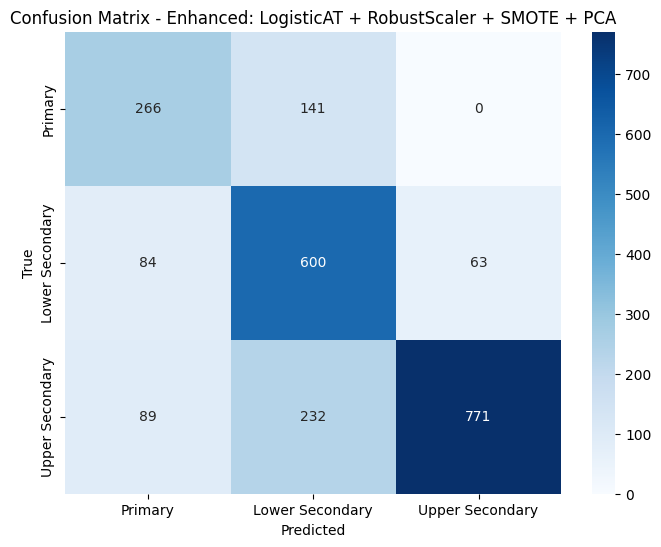


Ordinal Regression Coefficients (Higher absolute value = more important):
  stacked_word_ratio            :   0.1362 (|0.1362|)
  avg_word_length               :  -0.0748 (|0.0748|)
  conjunction_ratio             :   0.0390 (|0.0390|)
  ppm_ratio                     :  -0.0429 (|0.0429|)
  adv_ratio                     :   7.1457 (|7.1457|)
  proverb_ratio                 :   8.9726 (|8.9726|)
  Primary_WordRatio             :  -0.7089 (|0.7089|)
  Lower Secondary_WordRatio     :  -1.4526 (|1.4526|)
  Upper Secondary_WordRatio     :  -0.1090 (|0.1090|)
  G1_WordRatio                  :  -0.1242 (|0.1242|)
  G2_WordRatio                  :   1.2470 (|1.2470|)
  G3_WordRatio                  :   1.3487 (|1.3487|)
  G4_WordRatio                  :  -0.3301 (|0.3301|)
  G5_WordRatio                  :  -0.0473 (|0.0473|)
  G6_WordRatio                  :   0.9261 (|0.9261|)
  G7_WordRatio                  :  -0.1481 (|0.1481|)
  G8_WordRatio                  :   0.0696 (|0.0696|)
  G9_Wo

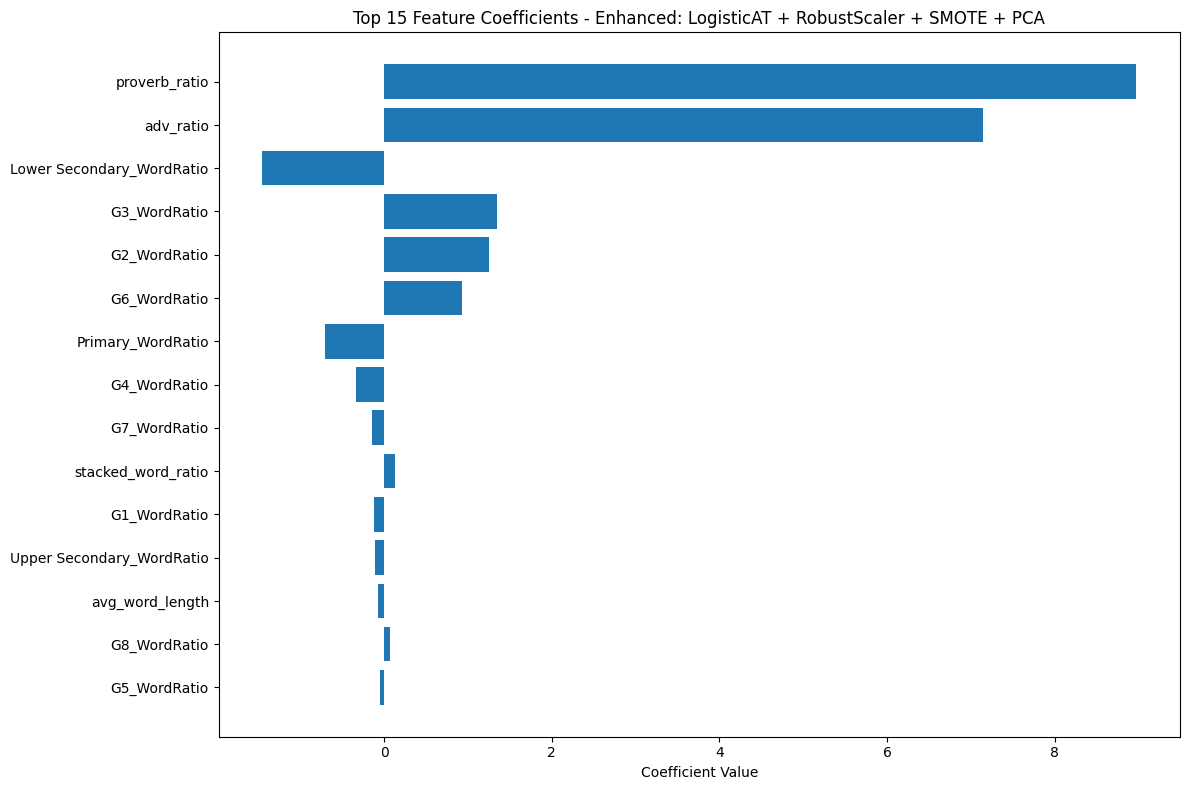

In [ ]:
# Enhanced Model 5: Different ordinal regression model

best_pipeline_5, best_score_5 = train_and_evaluate_enhanced(X_combined, y_level, label="Enhanced: LogisticAT + RobustScaler + SMOTE + PCA", use_smote=True, feature_selection=None, scaling='robust', pca_components=100, model_type='logistic_at')



=== Enhanced: LogisticSE + RobustScaler + SMOTE + PCA ===
Cross-validation Accuracy: 0.7187 (+/- 0.0099)
Test Accuracy: 0.7061442564559216

Classification Report:
Primary           : Precision=0.706, Recall=0.425, F1=0.531, Support=407
Lower Secondary   : Precision=0.550, Recall=0.867, F1=0.673, Support=747
Upper Secondary   : Precision=0.930, Recall=0.701, F1=0.799, Support=1092

Weighted Avg: Precision=0.7628, Recall=0.7061, F1=0.7085

Accuracy by Grade:
Grade
1     0.755319
2     0.543478
3     0.438596
4     0.305195
5     0.089286
6     0.890625
7     0.896552
8     0.869792
9     0.833992
10    0.577778
11    0.700405
12    0.774799
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


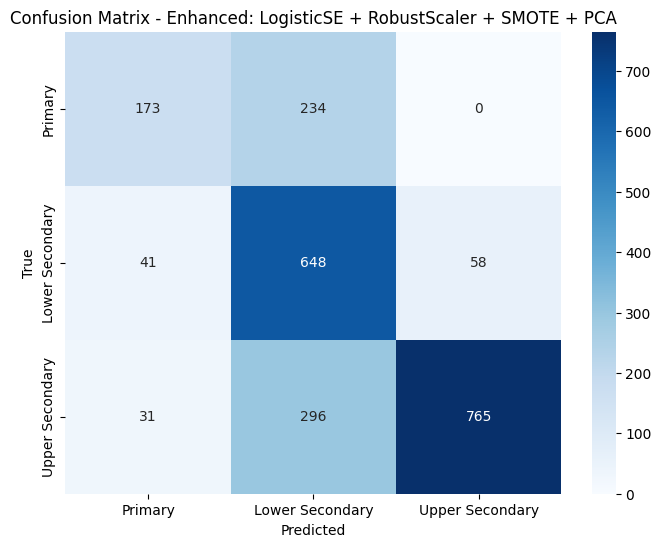


Ordinal Regression Coefficients (Higher absolute value = more important):
  stacked_word_ratio            :   0.1516 (|0.1516|)
  avg_word_length               :  -0.0831 (|0.0831|)
  conjunction_ratio             :   0.0499 (|0.0499|)
  ppm_ratio                     :  -0.0463 (|0.0463|)
  adv_ratio                     :   7.8854 (|7.8854|)
  proverb_ratio                 :   9.8497 (|9.8497|)
  Primary_WordRatio             :  -0.7893 (|0.7893|)
  Lower Secondary_WordRatio     :  -1.5890 (|1.5890|)
  Upper Secondary_WordRatio     :  -0.1190 (|0.1190|)
  G1_WordRatio                  :  -0.1511 (|0.1511|)
  G2_WordRatio                  :   1.3467 (|1.3467|)
  G3_WordRatio                  :   1.4013 (|1.4013|)
  G4_WordRatio                  :  -0.4267 (|0.4267|)
  G5_WordRatio                  :  -0.1176 (|0.1176|)
  G6_WordRatio                  :   0.9803 (|0.9803|)
  G7_WordRatio                  :  -0.1763 (|0.1763|)
  G8_WordRatio                  :   0.0771 (|0.0771|)
  G9_Wo

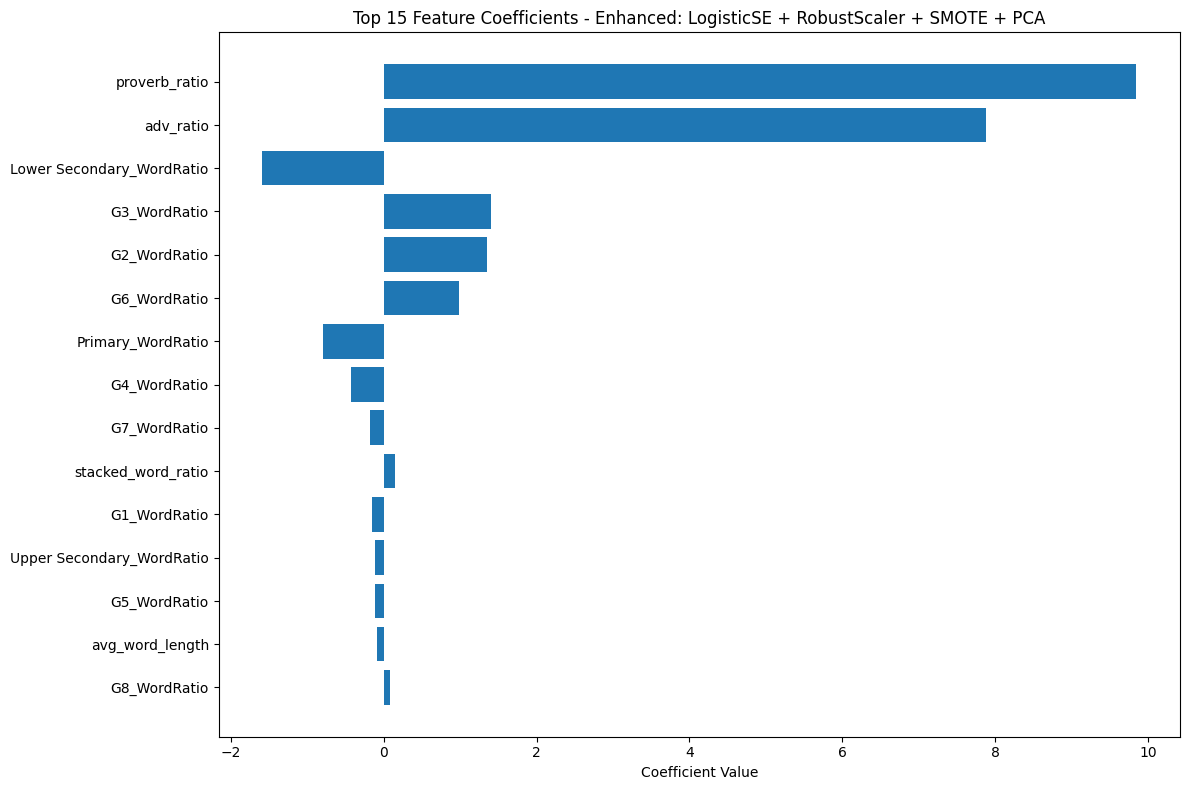

In [ ]:
# Enhanced Model 6: Different ordinal regression model

best_pipeline_6, best_score_6 = train_and_evaluate_enhanced(X_combined, y_level, label="Enhanced: LogisticSE + RobustScaler + SMOTE + PCA", use_smote=True, feature_selection=None, scaling='robust', pca_components=100, model_type='logistic_se')




=== Enhanced: Random Forest + RobustScaler + SMOTE + RFE ===
Cross-validation Accuracy: 0.8239 (+/- 0.0106)
Test Accuracy: 0.8192341941228851

Classification Report:
Primary           : Precision=0.704, Recall=0.916, F1=0.796, Support=407
Lower Secondary   : Precision=0.776, Recall=0.838, F1=0.806, Support=747
Upper Secondary   : Precision=0.925, Recall=0.770, F1=0.841, Support=1092

Weighted Avg: Precision=0.8354, Recall=0.8192, F1=0.8209

Accuracy by Grade:
Grade
1     0.968085
2     0.891304
3     1.000000
4     0.870130
5     0.892857
6     0.898438
7     0.862069
8     0.854167
9     0.778656
10    0.724444
11    0.748988
12    0.825737
dtype: float64


/tmp/ipython-input-1222620124.py:101: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grade_accuracy = df_grade.groupby('Grade').apply(lambda g: np.mean(g['True'] == g['Pred']))


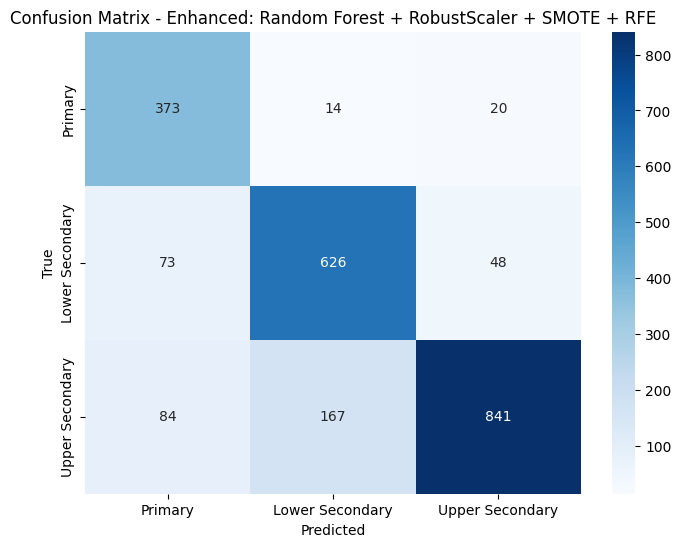

Features selected by RFE: 15 out of 21
Selected features: ['avg_word_length', 'conjunction_ratio', 'ppm_ratio', 'Primary_WordRatio', 'Lower Secondary_WordRatio', 'Upper Secondary_WordRatio', 'G1_WordRatio', 'G2_WordRatio', 'G3_WordRatio', 'G4_WordRatio', 'G5_WordRatio', 'G6_WordRatio', 'G7_WordRatio', 'G10_WordRatio', 'G11_WordRatio']

Random Forest Feature Importances:
  avg_word_length               : 0.0794
  conjunction_ratio             : 0.0267
  ppm_ratio                     : 0.0540
  Primary_WordRatio             : 0.1729
  Lower Secondary_WordRatio     : 0.1339
  Upper Secondary_WordRatio     : 0.1626
  G1_WordRatio                  : 0.0599
  G2_WordRatio                  : 0.0477
  G3_WordRatio                  : 0.0350
  G4_WordRatio                  : 0.0345
  G5_WordRatio                  : 0.0222
  G6_WordRatio                  : 0.0424
  G7_WordRatio                  : 0.0238
  G10_WordRatio                 : 0.0509
  G11_WordRatio                 : 0.0540

Top 10 Most

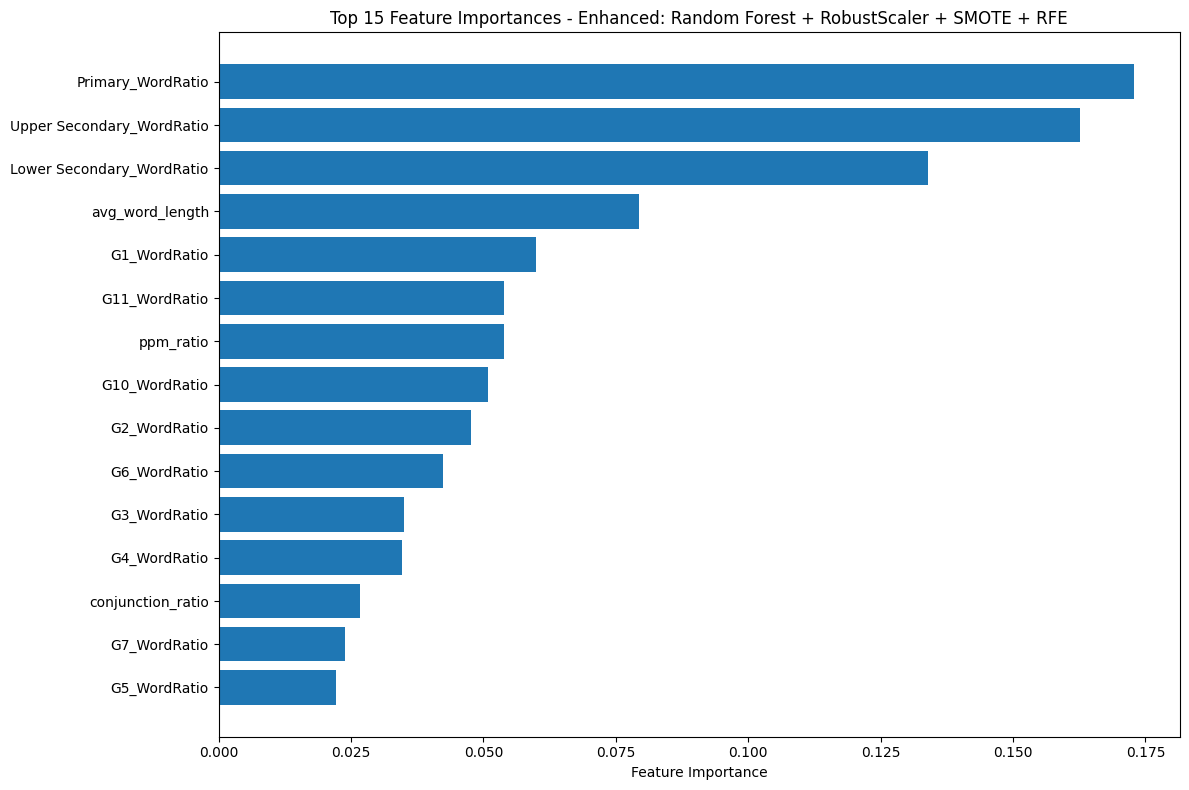

In [ ]:
# Enhanced Model 7: Random Forest Classifier alternative model

best_pipeline_7, best_score_7 = train_and_evaluate_enhanced(X_combined, y_level, label="Enhanced: Random Forest + RobustScaler + SMOTE + RFE", use_smote=True, feature_selection='rfe', scaling='robust', model_type='random_forest')



In [ ]:
results = [("Enhanced: Grade-Level Features", best_score_1), ("Enhanced: Level-Based Features", best_score_2), ("Enhanced: Combined Features", best_score_3), ("Enhanced: Combined + PCA", best_score_4), ("Enhanced: LogisticAT", best_score_5), ("Enhanced: LogisticSE", best_score_6), ("Enhanced: Random Forest Classifier", best_score_7),]

print("Cross-validation Accuracy Summary:")
results = sorted(results, key=lambda x: x[1], reverse=True)
for i, (name, score) in enumerate(results):
    print(f"{i+1:2d}. {name:35s}: {score:.4f}")


Cross-validation Accuracy Summary:
 1. Enhanced: Random Forest Classifier : 0.8239
 2. Enhanced: LogisticAT               : 0.7394
 3. Enhanced: Level-Based Features     : 0.7358
 4. Enhanced: Combined Features        : 0.7310
 5. Enhanced: Combined + PCA           : 0.7310
 6. Enhanced: Grade-Level Features     : 0.7287
 7. Enhanced: LogisticSE               : 0.7187


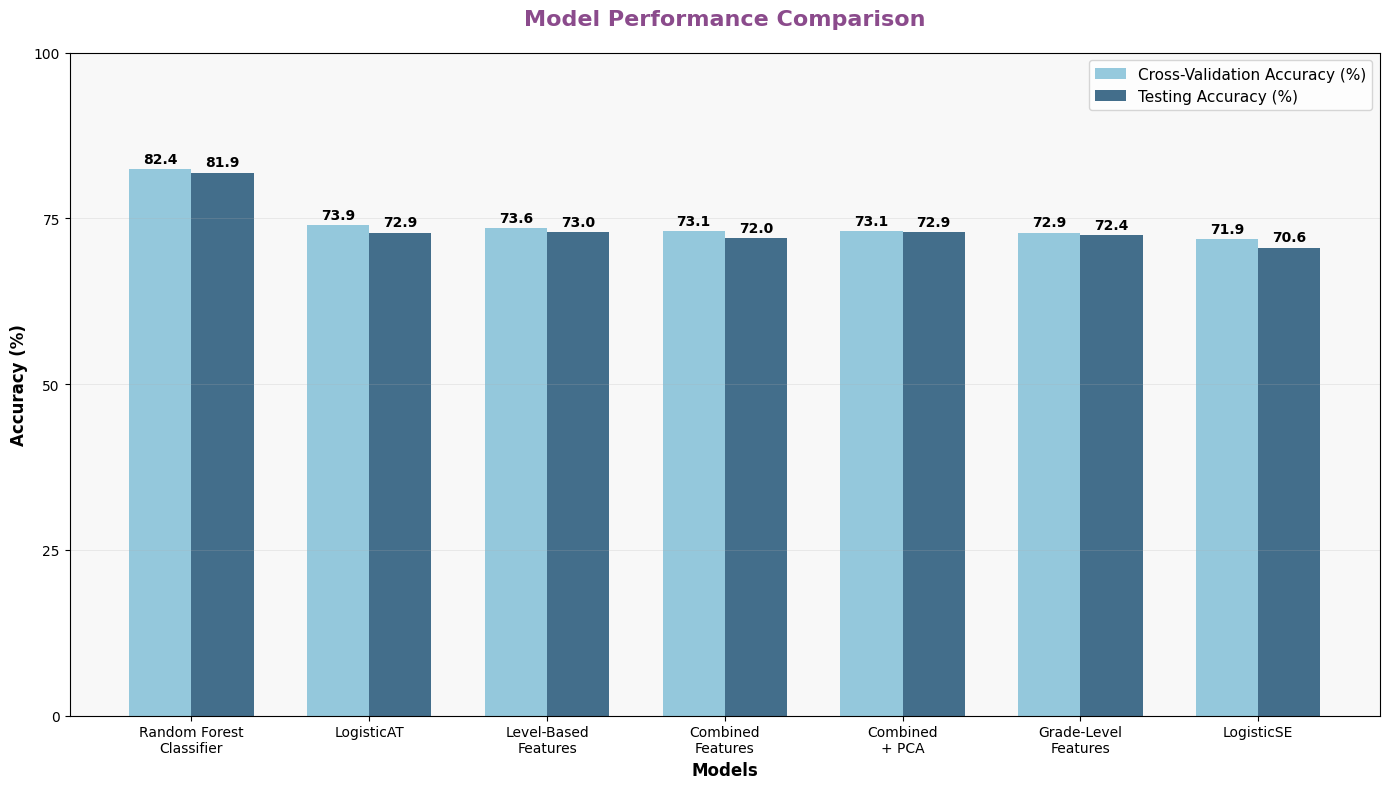


Cross-validation Accuracy Summary:
1. Random Forest Classifier: 0.8239
2. LogisticAT: 0.7394
3. Level-Based Features: 0.7358
4. Combined Features: 0.7310
5. Combined + PCA: 0.7310
6. Grade-Level Features: 0.7287
7. LogisticSE: 0.7187

Testing Accuracy Summary:
1. Random Forest Classifier: 0.8192
2. LogisticAT: 0.7288
3. Level-Based Features: 0.7297
4. Combined Features: 0.7199
5. Combined + PCA: 0.7292
6. Grade-Level Features: 0.7243
7. LogisticSE: 0.7061


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your results (converted to percentages)
models = ['Random Forest\nClassifier', 'LogisticAT', 'Level-Based\nFeatures',
          'Combined\nFeatures', 'Combined\n+ PCA', 'Grade-Level\nFeatures', 'LogisticSE']

# Cross-validation and testing accuracies (converted to percentages)
cross_validation_acc = [82.39, 73.94, 73.58, 73.10, 73.10, 72.87, 71.87]
testing_acc = [81.92, 72.88, 72.97, 71.99, 72.92, 72.43, 70.61]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Set the width of bars and positions
bar_width = 0.35
x_pos = np.arange(len(models))

# Create bars
bars1 = ax.bar(x_pos - bar_width/2, cross_validation_acc, bar_width,
               label='Cross-Validation Accuracy (%)', color='#7BBDD6', alpha=0.8)
bars2 = ax.bar(x_pos + bar_width/2, testing_acc, bar_width,
               label='Testing Accuracy (%)', color='#2F5F7F', alpha=0.9)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize the chart
ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold',
             color='#8B4B8C', pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(models, fontsize=10)

# Set y-axis limits and grid
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 25))
ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)

# Add legend
ax.legend(loc='upper right', fontsize=11)

# Set background color
ax.set_facecolor('#F8F8F8')
fig.patch.set_facecolor('white')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Print summary table
print("\nCross-validation Accuracy Summary:")
for i, (model, acc) in enumerate(zip(models, cross_validation_acc), 1):
    model_clean = model.replace('\n', ' ')
    print(f"{i}. {model_clean}: {acc/100:.4f}")

print("\nTesting Accuracy Summary:")
for i, (model, acc) in enumerate(zip(models, testing_acc), 1):
    model_clean = model.replace('\n', ' ')
    print(f"{i}. {model_clean}: {acc/100:.4f}")